# Imports

# Neutron/Photon Separation
Can it be done???

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Append source directory to path
sys.path.append("../../src/")

# Import custom modules
from ECALDataAnalyzer import ECALDataAnalyzer
from TrainData import load_zip_train_test_data, load_unzip_data
from model_functions import make_gravnet_model
from loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
from callbacks import PlotCallback, CyclicalLearningRate, LossPlotCallback
from helper_functions import create_output_directory, create_gif_from_pngs
from global_params import *
tf.config.list_physical_devices()

# Load Data

In [4]:
batch_size = 16         # Batch size
project_directory = '../../projects/ratsinthesky.10.08.2024.15.23/training/'
(train_X, train_y, train_misc), (test_X, test_y, test_misc) = load_zip_train_test_data(project_directory, batch_size=batch_size, max_files=1)
train_data = tf.data.Dataset.zip((train_X, train_y))
test_data = tf.data.Dataset.zip((test_X, test_y))

In [11]:
# Set training parameters
initial_lr = 1e-6       # Initial learning rate for CLR
max_lr = 1e-5           # Maximum learning rate for CLR
step_size = 20          # 20 batches for half cycle, so 40 batches for a full cycle
N_epochs = 300          # Number of epochs to train
q_min = 0.5             # q_min for the custom loss
tB = 0.1                # Minimum beta for clustering
tD = 0.25               # Minimum distance for clustering
ev_n = 1                # Event numbers to plot
alpha_p = 1             # Hyperparameter for weighing loss
# Produce new output directory for saving plots
outdir = create_output_directory("./out")

# Define the model
model = make_gravnet_model(
    K=100,
    N_feat=28,
    N_grav_layers=3,
    N_neighbors=6,
    N_filters=16,
    use_sector=False
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Instantiate the custom loss function
custom_loss = CustomLoss(q_min=q_min)

# Compile the model with the new LpLossMetric
model.compile(
    optimizer=optimizer,
    loss=custom_loss,
    metrics=[
        AttractiveLossMetric(q_min=q_min),
        RepulsiveLossMetric(q_min=q_min),
        CowardLossMetric(q_min=q_min),
        NoiseLossMetric(q_min=q_min),
        LpLossMetric(alpha_p=alpha_p) 
    ]
)

# Callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

clr_callback = CyclicalLearningRate(
    initial_learning_rate=initial_lr, 
    max_learning_rate=max_lr, 
    step_size=step_size
)

# Extract train and test data for plotting
for x in train_X.take(1):
    ecal_x_train = x[0:0+ev_n]
    break
for y in train_y.take(1):
    ecal_y_train = y[0:0+ev_n]
    break
for misc in train_misc.take(1):
    ecal_misc_train= misc[0:0+ev_n]
    break

for x in test_X.take(1):
    ecal_x_test = x[0:0+ev_n]
    break
for y in test_y.take(1):
    ecal_y_test = y[0:0+ev_n]
    break
for misc in test_misc.take(1):
    ecal_misc_test = misc[0:0+ev_n]
    break

# Plot callbacks for training and testing data
ecal_train_plot_callback = PlotCallback(
    X=ecal_x_train,
    y=ecal_y_train,
    misc=ecal_misc_train,
    tB=tB,
    tD=tD,
    outdir=outdir,
    version="train"
)

ecal_test_plot_callback = PlotCallback(
    X=ecal_x_test,
    y=ecal_y_test,
    misc=ecal_misc_test,
    tB=tB,
    tD=tD,
    outdir=outdir,
    version="test"
)

# Callback to plot loss metrics during training
loss_plot_callback = LossPlotCallback(
    save_dir=outdir
)

# Create checkpoint directory if it doesn't exist
os.makedirs(f'{outdir}/checkpoints',exist_ok=True)

# Checkpoint callback to save model at each epoch
checkpoint_callback = ModelCheckpoint(
    filepath=outdir+'/checkpoints/epoch_{epoch:02d}.keras',  # Save model to this file path, epoch will be part of the filename
    monitor='loss',                                       # You can monitor 'val_loss' or another metric if needed
    save_best_only=False,                                 # Set to True to save only the best model
    save_weights_only=False,                              # Set to True if you only want to save model weights
    save_freq='epoch',                                    # Save after every epoch
    verbose=0                                             # Print a message when the model is saved
)

# Output the number of parameters in the model
print("Number of Parameters:", model.count_params())

Number of Parameters: 22399


In [12]:
# Train the model
history = model.fit(train_data,
                    batch_size=batch_size,
                    epochs=N_epochs,
                    shuffle=False,
                    #validation_data=test_data,
                    callbacks=[#early_stopping_callback,
                               clr_callback,
                               ecal_train_plot_callback,
                               #ecal_test_plot_callback,
                               #loss_plot_callback,
                               #checkpoint_callback
                    ])

Epoch 1/300
     48/Unknown 7s 19ms/step - attractive_loss: 0.0748 - coward_loss: 0.4264 - loss: 1.5350 - noise_loss: 0.4991 - repulsive_loss: 0.5346

/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 62.81it/s]


End of epoch 1
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - attractive_loss: 0.0748 - coward_loss: 0.4266 - loss: 1.5344 - noise_loss: 0.4989 - repulsive_loss: 0.5336
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0714 - coward_loss: 0.4470 - loss: 1.4895 - noise_loss: 0.4948 - repulsive_loss: 0.476


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.92it/s]


End of epoch 2
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0713 - coward_loss: 0.4470 - loss: 1.4892 - noise_loss: 0.4946 - repulsive_loss: 0.4756
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0695 - coward_loss: 0.4615 - loss: 1.4487 - noise_loss: 0.4907 - repulsive_loss: 0.427


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 68.84it/s]


End of epoch 3
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0695 - coward_loss: 0.4614 - loss: 1.4485 - noise_loss: 0.4905 - repulsive_loss: 0.4266
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0688 - coward_loss: 0.4699 - loss: 1.4102 - noise_loss: 0.4870 - repulsive_loss: 0.384


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 67.00it/s]


End of epoch 4
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0688 - coward_loss: 0.4698 - loss: 1.4098 - noise_loss: 0.4868 - repulsive_loss: 0.3839
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0691 - coward_loss: 0.4747 - loss: 1.3687 - noise_loss: 0.4835 - repulsive_loss: 0.341


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.46it/s]


End of epoch 5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0691 - coward_loss: 0.4745 - loss: 1.3682 - noise_loss: 0.4833 - repulsive_loss: 0.3408
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0699 - coward_loss: 0.4770 - loss: 1.3245 - noise_loss: 0.4799 - repulsive_loss: 0.297


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 61.26it/s]


End of epoch 6
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0699 - coward_loss: 0.4768 - loss: 1.3241 - noise_loss: 0.4797 - repulsive_loss: 0.2973
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0700 - coward_loss: 0.4772 - loss: 1.2877 - noise_loss: 0.4765 - repulsive_loss: 0.264


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.96it/s]


End of epoch 7
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - attractive_loss: 0.0700 - coward_loss: 0.4769 - loss: 1.2876 - noise_loss: 0.4763 - repulsive_loss: 0.2639
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0693 - coward_loss: 0.4767 - loss: 1.2640 - noise_loss: 0.4732 - repulsive_loss: 0.244


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 85.18it/s]


End of epoch 8
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0693 - coward_loss: 0.4764 - loss: 1.2640 - noise_loss: 0.4730 - repulsive_loss: 0.2447
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0678 - coward_loss: 0.4760 - loss: 1.2465 - noise_loss: 0.4697 - repulsive_loss: 0.232


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 61.60it/s]


End of epoch 9
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0678 - coward_loss: 0.4758 - loss: 1.2464 - noise_loss: 0.4695 - repulsive_loss: 0.2329
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0661 - coward_loss: 0.4754 - loss: 1.2332 - noise_loss: 0.4659 - repulsive_loss: 0.225


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.74it/s]


End of epoch 10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0661 - coward_loss: 0.4752 - loss: 1.2332 - noise_loss: 0.4657 - repulsive_loss: 0.2258
Epoch 11/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0643 - coward_loss: 0.4746 - loss: 1.2223 - noise_loss: 0.4620 - repulsive_loss: 0.221


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.56it/s]


End of epoch 11
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0643 - coward_loss: 0.4744 - loss: 1.2224 - noise_loss: 0.4617 - repulsive_loss: 0.2215
Epoch 12/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.4738 - loss: 1.2126 - noise_loss: 0.4579 - repulsive_loss: 0.218


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 79.10it/s]


End of epoch 12
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - attractive_loss: 0.0627 - coward_loss: 0.4736 - loss: 1.2127 - noise_loss: 0.4577 - repulsive_loss: 0.2183
Epoch 13/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0612 - coward_loss: 0.4728 - loss: 1.2028 - noise_loss: 0.4534 - repulsive_loss: 0.215


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 79.30it/s]


End of epoch 13
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0612 - coward_loss: 0.4725 - loss: 1.2029 - noise_loss: 0.4532 - repulsive_loss: 0.2155
Epoch 14/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0600 - coward_loss: 0.4714 - loss: 1.1935 - noise_loss: 0.4485 - repulsive_loss: 0.213


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 57.46it/s]


End of epoch 14
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0600 - coward_loss: 0.4712 - loss: 1.1936 - noise_loss: 0.4483 - repulsive_loss: 0.2137
Epoch 15/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0591 - coward_loss: 0.4698 - loss: 1.1846 - noise_loss: 0.4435 - repulsive_loss: 0.212


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 79.18it/s]


End of epoch 15
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0591 - coward_loss: 0.4696 - loss: 1.1847 - noise_loss: 0.4433 - repulsive_loss: 0.2122
Epoch 16/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0581 - coward_loss: 0.4682 - loss: 1.1753 - noise_loss: 0.4382 - repulsive_loss: 0.210


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 54.23it/s]


End of epoch 16
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0581 - coward_loss: 0.4679 - loss: 1.1754 - noise_loss: 0.4379 - repulsive_loss: 0.2110
Epoch 17/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0575 - coward_loss: 0.4664 - loss: 1.1657 - noise_loss: 0.4321 - repulsive_loss: 0.209


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.59it/s]


End of epoch 17
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - attractive_loss: 0.0575 - coward_loss: 0.4662 - loss: 1.1657 - noise_loss: 0.4318 - repulsive_loss: 0.2098
Epoch 18/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0569 - coward_loss: 0.4643 - loss: 1.1555 - noise_loss: 0.4256 - repulsive_loss: 0.208


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 50.89it/s]


End of epoch 18
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - attractive_loss: 0.0569 - coward_loss: 0.4641 - loss: 1.1556 - noise_loss: 0.4253 - repulsive_loss: 0.2088
Epoch 19/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0565 - coward_loss: 0.4622 - loss: 1.1454 - noise_loss: 0.4189 - repulsive_loss: 0.207


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.32it/s]


End of epoch 19
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0565 - coward_loss: 0.4619 - loss: 1.1455 - noise_loss: 0.4186 - repulsive_loss: 0.2080
Epoch 20/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0561 - coward_loss: 0.4600 - loss: 1.1344 - noise_loss: 0.4113 - repulsive_loss: 0.207


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.74it/s]


End of epoch 20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0562 - coward_loss: 0.4598 - loss: 1.1345 - noise_loss: 0.4110 - repulsive_loss: 0.2071
Epoch 21/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0558 - coward_loss: 0.4579 - loss: 1.1220 - noise_loss: 0.4028 - repulsive_loss: 0.205


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 54.46it/s]


End of epoch 21
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - attractive_loss: 0.0559 - coward_loss: 0.4576 - loss: 1.1221 - noise_loss: 0.4025 - repulsive_loss: 0.2056
Epoch 22/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0557 - coward_loss: 0.4558 - loss: 1.1095 - noise_loss: 0.3939 - repulsive_loss: 0.204


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.95it/s]


End of epoch 22
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0557 - coward_loss: 0.4555 - loss: 1.1096 - noise_loss: 0.3936 - repulsive_loss: 0.2043
Epoch 23/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0557 - coward_loss: 0.4536 - loss: 1.0972 - noise_loss: 0.3845 - repulsive_loss: 0.203


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.59it/s]


End of epoch 23
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - attractive_loss: 0.0557 - coward_loss: 0.4533 - loss: 1.0972 - noise_loss: 0.3841 - repulsive_loss: 0.2035
Epoch 24/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0556 - coward_loss: 0.4515 - loss: 1.0824 - noise_loss: 0.3736 - repulsive_loss: 0.201


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 57.04it/s]


End of epoch 24
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0556 - coward_loss: 0.4512 - loss: 1.0824 - noise_loss: 0.3733 - repulsive_loss: 0.2018
Epoch 25/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0559 - coward_loss: 0.4489 - loss: 1.0670 - noise_loss: 0.3618 - repulsive_loss: 0.200


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 61.28it/s]


End of epoch 25
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0559 - coward_loss: 0.4487 - loss: 1.0671 - noise_loss: 0.3615 - repulsive_loss: 0.2005
Epoch 26/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0561 - coward_loss: 0.4463 - loss: 1.0514 - noise_loss: 0.3498 - repulsive_loss: 0.199


2024-10-04 12:10:17.640701: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 62.89it/s]


End of epoch 26
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0562 - coward_loss: 0.4460 - loss: 1.0514 - noise_loss: 0.3495 - repulsive_loss: 0.1993
Epoch 27/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0560 - coward_loss: 0.4440 - loss: 1.0347 - noise_loss: 0.3368 - repulsive_loss: 0.197


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.22it/s]


End of epoch 27
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0561 - coward_loss: 0.4437 - loss: 1.0346 - noise_loss: 0.3364 - repulsive_loss: 0.1980
Epoch 28/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0567 - coward_loss: 0.4412 - loss: 1.0165 - noise_loss: 0.3221 - repulsive_loss: 0.196


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.26it/s]


End of epoch 28
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0568 - coward_loss: 0.4409 - loss: 1.0165 - noise_loss: 0.3219 - repulsive_loss: 0.1965
Epoch 29/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0572 - coward_loss: 0.4383 - loss: 0.9982 - noise_loss: 0.3071 - repulsive_loss: 0.195


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 79.07it/s]


End of epoch 29
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0573 - coward_loss: 0.4381 - loss: 0.9981 - noise_loss: 0.3068 - repulsive_loss: 0.1956
Epoch 30/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0576 - coward_loss: 0.4358 - loss: 0.9795 - noise_loss: 0.2921 - repulsive_loss: 0.194


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.70it/s]


End of epoch 30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - attractive_loss: 0.0576 - coward_loss: 0.4356 - loss: 0.9794 - noise_loss: 0.2918 - repulsive_loss: 0.1941
Epoch 31/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0582 - coward_loss: 0.4327 - loss: 0.9596 - noise_loss: 0.2760 - repulsive_loss: 0.192


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.47it/s]


End of epoch 31
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0582 - coward_loss: 0.4325 - loss: 0.9595 - noise_loss: 0.2757 - repulsive_loss: 0.1928
Epoch 32/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0589 - coward_loss: 0.4291 - loss: 0.9393 - noise_loss: 0.2590 - repulsive_loss: 0.192


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.46it/s]


End of epoch 32
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0589 - coward_loss: 0.4289 - loss: 0.9393 - noise_loss: 0.2589 - repulsive_loss: 0.1923
Epoch 33/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - attractive_loss: 0.0593 - coward_loss: 0.4257 - loss: 0.9188 - noise_loss: 0.2429 - repulsive_loss: 0.190


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.34it/s]


End of epoch 33
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0594 - coward_loss: 0.4254 - loss: 0.9187 - noise_loss: 0.2427 - repulsive_loss: 0.1909
Epoch 34/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0598 - coward_loss: 0.4227 - loss: 0.8990 - noise_loss: 0.2272 - repulsive_loss: 0.189


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.88it/s]


End of epoch 34
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0599 - coward_loss: 0.4224 - loss: 0.8989 - noise_loss: 0.2268 - repulsive_loss: 0.1894
Epoch 35/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0611 - coward_loss: 0.4191 - loss: 0.8793 - noise_loss: 0.2109 - repulsive_loss: 0.188


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 73.52it/s]


End of epoch 35
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0612 - coward_loss: 0.4188 - loss: 0.8793 - noise_loss: 0.2105 - repulsive_loss: 0.1884
Epoch 36/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0617 - coward_loss: 0.4146 - loss: 0.8597 - noise_loss: 0.1951 - repulsive_loss: 0.188


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 78.76it/s]


End of epoch 36
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0617 - coward_loss: 0.4143 - loss: 0.8597 - noise_loss: 0.1948 - repulsive_loss: 0.1885
Epoch 37/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0620 - coward_loss: 0.4116 - loss: 0.8417 - noise_loss: 0.1809 - repulsive_loss: 0.187


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 62.69it/s]


End of epoch 37
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0621 - coward_loss: 0.4113 - loss: 0.8417 - noise_loss: 0.1806 - repulsive_loss: 0.1873
Epoch 38/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0625 - coward_loss: 0.4086 - loss: 0.8250 - noise_loss: 0.1673 - repulsive_loss: 0.186


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.48it/s]


End of epoch 38
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0626 - coward_loss: 0.4083 - loss: 0.8249 - noise_loss: 0.1670 - repulsive_loss: 0.1867
Epoch 39/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0630 - coward_loss: 0.4044 - loss: 0.8074 - noise_loss: 0.1539 - repulsive_loss: 0.186


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 68.62it/s]


End of epoch 39
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - attractive_loss: 0.0631 - coward_loss: 0.4041 - loss: 0.8074 - noise_loss: 0.1537 - repulsive_loss: 0.1862
Epoch 40/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0636 - coward_loss: 0.3999 - loss: 0.7910 - noise_loss: 0.1419 - repulsive_loss: 0.185


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 69.12it/s]


End of epoch 40
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0636 - coward_loss: 0.3995 - loss: 0.7910 - noise_loss: 0.1417 - repulsive_loss: 0.1858
Epoch 41/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0638 - coward_loss: 0.3969 - loss: 0.7772 - noise_loss: 0.1313 - repulsive_loss: 0.185


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.60it/s]


End of epoch 41
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0638 - coward_loss: 0.3966 - loss: 0.7772 - noise_loss: 0.1311 - repulsive_loss: 0.1854
Epoch 42/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0642 - coward_loss: 0.3933 - loss: 0.7636 - noise_loss: 0.1212 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 69.68it/s]


End of epoch 42
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0643 - coward_loss: 0.3929 - loss: 0.7636 - noise_loss: 0.1210 - repulsive_loss: 0.1850
Epoch 43/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0642 - coward_loss: 0.3895 - loss: 0.7507 - noise_loss: 0.1118 - repulsive_loss: 0.185


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 70.16it/s]


End of epoch 43
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0643 - coward_loss: 0.3891 - loss: 0.7508 - noise_loss: 0.1116 - repulsive_loss: 0.1854
Epoch 44/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0648 - coward_loss: 0.3863 - loss: 0.7396 - noise_loss: 0.1036 - repulsive_loss: 0.185


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 58.08it/s]


End of epoch 44
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0648 - coward_loss: 0.3861 - loss: 0.7396 - noise_loss: 0.1035 - repulsive_loss: 0.1850
Epoch 45/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0649 - coward_loss: 0.3842 - loss: 0.7295 - noise_loss: 0.0963 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.25it/s]


End of epoch 45
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0650 - coward_loss: 0.3839 - loss: 0.7295 - noise_loss: 0.0962 - repulsive_loss: 0.1841
Epoch 46/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0648 - coward_loss: 0.3806 - loss: 0.7195 - noise_loss: 0.0894 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 63.26it/s]


End of epoch 46
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0649 - coward_loss: 0.3803 - loss: 0.7195 - noise_loss: 0.0893 - repulsive_loss: 0.1848
Epoch 47/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0643 - coward_loss: 0.3776 - loss: 0.7101 - noise_loss: 0.0831 - repulsive_loss: 0.185


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.75it/s]


End of epoch 47
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0644 - coward_loss: 0.3772 - loss: 0.7102 - noise_loss: 0.0830 - repulsive_loss: 0.1852
Epoch 48/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0641 - coward_loss: 0.3762 - loss: 0.7024 - noise_loss: 0.0778 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.79it/s]


End of epoch 48
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0642 - coward_loss: 0.3758 - loss: 0.7025 - noise_loss: 0.0777 - repulsive_loss: 0.1845
Epoch 49/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0643 - coward_loss: 0.3731 - loss: 0.6949 - noise_loss: 0.0728 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.34it/s]


End of epoch 49
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0643 - coward_loss: 0.3728 - loss: 0.6950 - noise_loss: 0.0727 - repulsive_loss: 0.1849
Epoch 50/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0639 - coward_loss: 0.3712 - loss: 0.6879 - noise_loss: 0.0680 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 51.25it/s]


End of epoch 50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - attractive_loss: 0.0640 - coward_loss: 0.3709 - loss: 0.6880 - noise_loss: 0.0679 - repulsive_loss: 0.1849
Epoch 51/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0640 - coward_loss: 0.3682 - loss: 0.6810 - noise_loss: 0.0638 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 73.93it/s]


End of epoch 51
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0641 - coward_loss: 0.3680 - loss: 0.6810 - noise_loss: 0.0638 - repulsive_loss: 0.1850
Epoch 52/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0640 - coward_loss: 0.3665 - loss: 0.6751 - noise_loss: 0.0602 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.81it/s]


End of epoch 52
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0641 - coward_loss: 0.3662 - loss: 0.6752 - noise_loss: 0.0601 - repulsive_loss: 0.1845
Epoch 53/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0641 - coward_loss: 0.3641 - loss: 0.6696 - noise_loss: 0.0567 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.72it/s]


End of epoch 53
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0642 - coward_loss: 0.3637 - loss: 0.6697 - noise_loss: 0.0567 - repulsive_loss: 0.1848
Epoch 54/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0635 - coward_loss: 0.3632 - loss: 0.6640 - noise_loss: 0.0535 - repulsive_loss: 0.184


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.99it/s]


End of epoch 54
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0635 - coward_loss: 0.3628 - loss: 0.6641 - noise_loss: 0.0534 - repulsive_loss: 0.1842
Epoch 55/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0634 - coward_loss: 0.3613 - loss: 0.6589 - noise_loss: 0.0506 - repulsive_loss: 0.183


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 68.20it/s]


End of epoch 55
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0635 - coward_loss: 0.3610 - loss: 0.6590 - noise_loss: 0.0506 - repulsive_loss: 0.1836
Epoch 56/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepep - attractive_loss: 0.0634 - coward_loss: 0.3592 - loss: 0.6536 - noise_loss: 0.0481 - repulsive_loss: 0.183


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.68it/s]


End of epoch 56
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0635 - coward_loss: 0.3588 - loss: 0.6537 - noise_loss: 0.0480 - repulsive_loss: 0.1831
Epoch 57/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0634 - coward_loss: 0.3578 - loss: 0.6487 - noise_loss: 0.0456 - repulsive_loss: 0.182


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 80.73it/s]


End of epoch 57
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0634 - coward_loss: 0.3574 - loss: 0.6489 - noise_loss: 0.0455 - repulsive_loss: 0.1822
Epoch 58/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0634 - coward_loss: 0.3561 - loss: 0.6444 - noise_loss: 0.0433 - repulsive_loss: 0.181


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 85.67it/s]


End of epoch 58
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0635 - coward_loss: 0.3557 - loss: 0.6445 - noise_loss: 0.0433 - repulsive_loss: 0.1818
Epoch 59/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0636 - coward_loss: 0.3544 - loss: 0.6404 - noise_loss: 0.0413 - repulsive_loss: 0.181


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.45it/s]


End of epoch 59
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0636 - coward_loss: 0.3540 - loss: 0.6405 - noise_loss: 0.0413 - repulsive_loss: 0.1814
Epoch 60/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0632 - coward_loss: 0.3517 - loss: 0.6359 - noise_loss: 0.0394 - repulsive_loss: 0.181


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 54.42it/s]


End of epoch 60
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0633 - coward_loss: 0.3513 - loss: 0.6361 - noise_loss: 0.0394 - repulsive_loss: 0.1818
Epoch 61/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0625 - coward_loss: 0.3520 - loss: 0.6321 - noise_loss: 0.0376 - repulsive_loss: 0.180


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.72it/s]


End of epoch 61
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0626 - coward_loss: 0.3516 - loss: 0.6323 - noise_loss: 0.0376 - repulsive_loss: 0.1803
Epoch 62/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0623 - coward_loss: 0.3503 - loss: 0.6284 - noise_loss: 0.0360 - repulsive_loss: 0.179


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.64it/s]


End of epoch 62
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0624 - coward_loss: 0.3499 - loss: 0.6286 - noise_loss: 0.0359 - repulsive_loss: 0.1801
Epoch 63/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0625 - coward_loss: 0.3487 - loss: 0.6252 - noise_loss: 0.0345 - repulsive_loss: 0.179


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.93it/s]


End of epoch 63
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0626 - coward_loss: 0.3483 - loss: 0.6254 - noise_loss: 0.0345 - repulsive_loss: 0.1797
Epoch 64/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3467 - loss: 0.6221 - noise_loss: 0.0331 - repulsive_loss: 0.179


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.26it/s]


End of epoch 64
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0628 - coward_loss: 0.3464 - loss: 0.6222 - noise_loss: 0.0331 - repulsive_loss: 0.1798
Epoch 65/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0624 - coward_loss: 0.3469 - loss: 0.6192 - noise_loss: 0.0317 - repulsive_loss: 0.178


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 60.36it/s]


End of epoch 65
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - attractive_loss: 0.0625 - coward_loss: 0.3465 - loss: 0.6193 - noise_loss: 0.0317 - repulsive_loss: 0.1784
Epoch 66/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - attractive_loss: 0.0624 - coward_loss: 0.3452 - loss: 0.6162 - noise_loss: 0.0305 - repulsive_loss: 0.178


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 78.22it/s]


End of epoch 66
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0625 - coward_loss: 0.3449 - loss: 0.6163 - noise_loss: 0.0305 - repulsive_loss: 0.1782
Epoch 67/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - attractive_loss: 0.0626 - coward_loss: 0.3432 - loss: 0.6134 - noise_loss: 0.0294 - repulsive_loss: 0.178


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.42it/s]


End of epoch 67
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0627 - coward_loss: 0.3428 - loss: 0.6135 - noise_loss: 0.0294 - repulsive_loss: 0.1784
Epoch 68/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0628 - coward_loss: 0.3418 - loss: 0.6108 - noise_loss: 0.0283 - repulsive_loss: 0.177


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 70.39it/s]


End of epoch 68
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0629 - coward_loss: 0.3415 - loss: 0.6109 - noise_loss: 0.0283 - repulsive_loss: 0.1780
Epoch 69/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0625 - coward_loss: 0.3412 - loss: 0.6078 - noise_loss: 0.0272 - repulsive_loss: 0.176


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.27it/s]


End of epoch 69
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - attractive_loss: 0.0626 - coward_loss: 0.3408 - loss: 0.6079 - noise_loss: 0.0272 - repulsive_loss: 0.1770
Epoch 70/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3409 - loss: 0.6057 - noise_loss: 0.0263 - repulsive_loss: 0.175


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.70it/s]


End of epoch 70
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - attractive_loss: 0.0628 - coward_loss: 0.3405 - loss: 0.6058 - noise_loss: 0.0263 - repulsive_loss: 0.1761
Epoch 71/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0628 - coward_loss: 0.3382 - loss: 0.6027 - noise_loss: 0.0254 - repulsive_loss: 0.176


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.42it/s]


End of epoch 71
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0629 - coward_loss: 0.3378 - loss: 0.6029 - noise_loss: 0.0254 - repulsive_loss: 0.1766
Epoch 72/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0626 - coward_loss: 0.3382 - loss: 0.6007 - noise_loss: 0.0245 - repulsive_loss: 0.175


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 61.61it/s]


End of epoch 72
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0627 - coward_loss: 0.3379 - loss: 0.6008 - noise_loss: 0.0245 - repulsive_loss: 0.1755
Epoch 73/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3377 - loss: 0.5988 - noise_loss: 0.0238 - repulsive_loss: 0.174


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.67it/s]


End of epoch 73
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0627 - coward_loss: 0.3375 - loss: 0.5989 - noise_loss: 0.0237 - repulsive_loss: 0.1748
Epoch 74/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0626 - coward_loss: 0.3366 - loss: 0.5966 - noise_loss: 0.0230 - repulsive_loss: 0.174


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.93it/s]


End of epoch 74
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0627 - coward_loss: 0.3363 - loss: 0.5966 - noise_loss: 0.0230 - repulsive_loss: 0.1744
Epoch 75/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0626 - coward_loss: 0.3348 - loss: 0.5944 - noise_loss: 0.0223 - repulsive_loss: 0.174


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.32it/s]


End of epoch 75
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0627 - coward_loss: 0.3344 - loss: 0.5945 - noise_loss: 0.0223 - repulsive_loss: 0.1748
Epoch 76/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3342 - loss: 0.5921 - noise_loss: 0.0216 - repulsive_loss: 0.173


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.95it/s]


End of epoch 76
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0627 - coward_loss: 0.3339 - loss: 0.5923 - noise_loss: 0.0216 - repulsive_loss: 0.1738
Epoch 77/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0628 - coward_loss: 0.3342 - loss: 0.5903 - noise_loss: 0.0210 - repulsive_loss: 0.172


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 54.62it/s]


End of epoch 77
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0628 - coward_loss: 0.3339 - loss: 0.5904 - noise_loss: 0.0210 - repulsive_loss: 0.1724
Epoch 78/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0629 - coward_loss: 0.3326 - loss: 0.5882 - noise_loss: 0.0204 - repulsive_loss: 0.172


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 67.99it/s]


End of epoch 78
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0630 - coward_loss: 0.3322 - loss: 0.5884 - noise_loss: 0.0204 - repulsive_loss: 0.1726
Epoch 79/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3315 - loss: 0.5860 - noise_loss: 0.0198 - repulsive_loss: 0.171


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 52.43it/s]


End of epoch 79
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0628 - coward_loss: 0.3313 - loss: 0.5860 - noise_loss: 0.0198 - repulsive_loss: 0.1720
Epoch 80/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0626 - coward_loss: 0.3311 - loss: 0.5843 - noise_loss: 0.0192 - repulsive_loss: 0.171


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 60.02it/s]


End of epoch 80
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0627 - coward_loss: 0.3308 - loss: 0.5845 - noise_loss: 0.0192 - repulsive_loss: 0.1716
Epoch 81/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3306 - loss: 0.5821 - noise_loss: 0.0187 - repulsive_loss: 0.170


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 70.84it/s]


End of epoch 81
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0628 - coward_loss: 0.3302 - loss: 0.5822 - noise_loss: 0.0187 - repulsive_loss: 0.1704
Epoch 82/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0630 - coward_loss: 0.3282 - loss: 0.5803 - noise_loss: 0.0182 - repulsive_loss: 0.170


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.14it/s]


End of epoch 82
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0630 - coward_loss: 0.3279 - loss: 0.5804 - noise_loss: 0.0182 - repulsive_loss: 0.1710
Epoch 83/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3279 - loss: 0.5784 - noise_loss: 0.0177 - repulsive_loss: 0.170


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.67it/s]


End of epoch 83
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - attractive_loss: 0.0627 - coward_loss: 0.3276 - loss: 0.5785 - noise_loss: 0.0177 - repulsive_loss: 0.1703
Epoch 84/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3273 - loss: 0.5767 - noise_loss: 0.0173 - repulsive_loss: 0.169


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.05it/s]


End of epoch 84
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0627 - coward_loss: 0.3271 - loss: 0.5768 - noise_loss: 0.0173 - repulsive_loss: 0.1695
Epoch 85/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0629 - coward_loss: 0.3264 - loss: 0.5752 - noise_loss: 0.0168 - repulsive_loss: 0.169


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 91.42it/s]


End of epoch 85
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - attractive_loss: 0.0630 - coward_loss: 0.3262 - loss: 0.5753 - noise_loss: 0.0168 - repulsive_loss: 0.1691
Epoch 86/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3252 - loss: 0.5731 - noise_loss: 0.0164 - repulsive_loss: 0.168


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 102.87it/s]


End of epoch 86
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0627 - coward_loss: 0.3249 - loss: 0.5732 - noise_loss: 0.0164 - repulsive_loss: 0.1690
Epoch 87/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0626 - coward_loss: 0.3252 - loss: 0.5718 - noise_loss: 0.0160 - repulsive_loss: 0.168


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.00it/s]


End of epoch 87
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0627 - coward_loss: 0.3248 - loss: 0.5719 - noise_loss: 0.0160 - repulsive_loss: 0.1681
Epoch 88/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3247 - loss: 0.5700 - noise_loss: 0.0156 - repulsive_loss: 0.167


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 107.41it/s]


End of epoch 88
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0627 - coward_loss: 0.3243 - loss: 0.5701 - noise_loss: 0.0156 - repulsive_loss: 0.1672
Epoch 89/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0629 - coward_loss: 0.3231 - loss: 0.5683 - noise_loss: 0.0153 - repulsive_loss: 0.167


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 113.31it/s]


End of epoch 89
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0630 - coward_loss: 0.3226 - loss: 0.5684 - noise_loss: 0.0153 - repulsive_loss: 0.1673
Epoch 90/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0625 - coward_loss: 0.3229 - loss: 0.5666 - noise_loss: 0.0149 - repulsive_loss: 0.166


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 98.22it/s]


End of epoch 90
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0626 - coward_loss: 0.3226 - loss: 0.5666 - noise_loss: 0.0149 - repulsive_loss: 0.1663
Epoch 91/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0627 - coward_loss: 0.3217 - loss: 0.5650 - noise_loss: 0.0145 - repulsive_loss: 0.166


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 69.90it/s]


End of epoch 91
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0628 - coward_loss: 0.3214 - loss: 0.5651 - noise_loss: 0.0145 - repulsive_loss: 0.1661
Epoch 92/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0630 - coward_loss: 0.3206 - loss: 0.5635 - noise_loss: 0.0142 - repulsive_loss: 0.165


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 99.73it/s]


End of epoch 92
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0631 - coward_loss: 0.3202 - loss: 0.5636 - noise_loss: 0.0142 - repulsive_loss: 0.1659
Epoch 93/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0632 - coward_loss: 0.3192 - loss: 0.5621 - noise_loss: 0.0139 - repulsive_loss: 0.165


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 92.44it/s]


End of epoch 93
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0632 - coward_loss: 0.3190 - loss: 0.5621 - noise_loss: 0.0139 - repulsive_loss: 0.1658
Epoch 94/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0632 - coward_loss: 0.3194 - loss: 0.5606 - noise_loss: 0.0136 - repulsive_loss: 0.164


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.14it/s]


End of epoch 94
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0632 - coward_loss: 0.3191 - loss: 0.5607 - noise_loss: 0.0136 - repulsive_loss: 0.1646
Epoch 95/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0636 - coward_loss: 0.3179 - loss: 0.5590 - noise_loss: 0.0133 - repulsive_loss: 0.164


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 100.86it/s]


End of epoch 95
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - attractive_loss: 0.0636 - coward_loss: 0.3176 - loss: 0.5591 - noise_loss: 0.0133 - repulsive_loss: 0.1644
Epoch 96/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0638 - coward_loss: 0.3174 - loss: 0.5579 - noise_loss: 0.0130 - repulsive_loss: 0.163


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 96.46it/s]


End of epoch 96
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0639 - coward_loss: 0.3170 - loss: 0.5580 - noise_loss: 0.0130 - repulsive_loss: 0.1638
Epoch 97/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0640 - coward_loss: 0.3168 - loss: 0.5568 - noise_loss: 0.0127 - repulsive_loss: 0.163


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.82it/s]


End of epoch 97
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0640 - coward_loss: 0.3165 - loss: 0.5569 - noise_loss: 0.0127 - repulsive_loss: 0.1634
Epoch 98/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - attractive_loss: 0.0638 - coward_loss: 0.3157 - loss: 0.5552 - noise_loss: 0.0125 - repulsive_loss: 0.163


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 88.77it/s]


End of epoch 98
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - attractive_loss: 0.0638 - coward_loss: 0.3155 - loss: 0.5553 - noise_loss: 0.0125 - repulsive_loss: 0.1633
Epoch 99/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0639 - coward_loss: 0.3152 - loss: 0.5537 - noise_loss: 0.0122 - repulsive_loss: 0.162


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 78.85it/s]


End of epoch 99
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0640 - coward_loss: 0.3149 - loss: 0.5537 - noise_loss: 0.0122 - repulsive_loss: 0.1624
Epoch 100/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0641 - coward_loss: 0.3140 - loss: 0.5525 - noise_loss: 0.0120 - repulsive_loss: 0.162


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 103.45it/s]


End of epoch 100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0642 - coward_loss: 0.3137 - loss: 0.5526 - noise_loss: 0.0120 - repulsive_loss: 0.1624
Epoch 101/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0639 - coward_loss: 0.3137 - loss: 0.5507 - noise_loss: 0.0118 - repulsive_loss: 0.161


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 98.73it/s]


End of epoch 101
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0640 - coward_loss: 0.3135 - loss: 0.5508 - noise_loss: 0.0118 - repulsive_loss: 0.1613
Epoch 102/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0640 - coward_loss: 0.3130 - loss: 0.5492 - noise_loss: 0.0115 - repulsive_loss: 0.160


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 109.70it/s]


End of epoch 102
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0640 - coward_loss: 0.3127 - loss: 0.5493 - noise_loss: 0.0115 - repulsive_loss: 0.1609
Epoch 103/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0635 - coward_loss: 0.3121 - loss: 0.5470 - noise_loss: 0.0113 - repulsive_loss: 0.160


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.31it/s]


End of epoch 103
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - attractive_loss: 0.0635 - coward_loss: 0.3117 - loss: 0.5471 - noise_loss: 0.0113 - repulsive_loss: 0.1604
Epoch 104/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0635 - coward_loss: 0.3110 - loss: 0.5454 - noise_loss: 0.0111 - repulsive_loss: 0.159


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.36it/s]


End of epoch 104
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0635 - coward_loss: 0.3107 - loss: 0.5454 - noise_loss: 0.0111 - repulsive_loss: 0.1599
Epoch 105/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0640 - coward_loss: 0.3114 - loss: 0.5448 - noise_loss: 0.0109 - repulsive_loss: 0.158


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 97.54it/s]


End of epoch 105
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0641 - coward_loss: 0.3110 - loss: 0.5449 - noise_loss: 0.0109 - repulsive_loss: 0.1586
Epoch 106/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0637 - coward_loss: 0.3098 - loss: 0.5427 - noise_loss: 0.0107 - repulsive_loss: 0.158


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 101.89it/s]


End of epoch 106
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0638 - coward_loss: 0.3094 - loss: 0.5428 - noise_loss: 0.0107 - repulsive_loss: 0.1586
Epoch 107/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0641 - coward_loss: 0.3088 - loss: 0.5414 - noise_loss: 0.0105 - repulsive_loss: 0.157


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 58.81it/s]


End of epoch 107
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0642 - coward_loss: 0.3085 - loss: 0.5415 - noise_loss: 0.0105 - repulsive_loss: 0.1581
Epoch 108/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0648 - coward_loss: 0.3090 - loss: 0.5410 - noise_loss: 0.0103 - repulsive_loss: 0.156


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 91.75it/s]


End of epoch 108
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0649 - coward_loss: 0.3086 - loss: 0.5410 - noise_loss: 0.0103 - repulsive_loss: 0.1571
Epoch 109/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0648 - coward_loss: 0.3080 - loss: 0.5395 - noise_loss: 0.0101 - repulsive_loss: 0.156


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.31it/s]


End of epoch 109
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - attractive_loss: 0.0648 - coward_loss: 0.3077 - loss: 0.5395 - noise_loss: 0.0101 - repulsive_loss: 0.1567
Epoch 110/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0651 - coward_loss: 0.3071 - loss: 0.5384 - noise_loss: 0.0099 - repulsive_loss: 0.156


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.85it/s]


End of epoch 110
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0652 - coward_loss: 0.3068 - loss: 0.5384 - noise_loss: 0.0099 - repulsive_loss: 0.1563
Epoch 111/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0653 - coward_loss: 0.3056 - loss: 0.5368 - noise_loss: 0.0098 - repulsive_loss: 0.156


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 99.76it/s]


End of epoch 111
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - attractive_loss: 0.0654 - coward_loss: 0.3053 - loss: 0.5369 - noise_loss: 0.0098 - repulsive_loss: 0.1563
Epoch 112/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0649 - coward_loss: 0.3061 - loss: 0.5353 - noise_loss: 0.0096 - repulsive_loss: 0.154


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.26it/s]


End of epoch 112
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0650 - coward_loss: 0.3057 - loss: 0.5354 - noise_loss: 0.0096 - repulsive_loss: 0.1548
Epoch 113/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0654 - coward_loss: 0.3050 - loss: 0.5343 - noise_loss: 0.0094 - repulsive_loss: 0.154


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 105.06it/s]


End of epoch 113
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - attractive_loss: 0.0655 - coward_loss: 0.3046 - loss: 0.5344 - noise_loss: 0.0094 - repulsive_loss: 0.1547
Epoch 114/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0657 - coward_loss: 0.3039 - loss: 0.5330 - noise_loss: 0.0093 - repulsive_loss: 0.154


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 102.31it/s]


End of epoch 114
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0658 - coward_loss: 0.3036 - loss: 0.5331 - noise_loss: 0.0093 - repulsive_loss: 0.1543
Epoch 115/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0659 - coward_loss: 0.3033 - loss: 0.5318 - noise_loss: 0.0091 - repulsive_loss: 0.153


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 100.49it/s]


End of epoch 115
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0660 - coward_loss: 0.3029 - loss: 0.5319 - noise_loss: 0.0091 - repulsive_loss: 0.1537
Epoch 116/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0662 - coward_loss: 0.3038 - loss: 0.5307 - noise_loss: 0.0090 - repulsive_loss: 0.151


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 58.59it/s]


End of epoch 116
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - attractive_loss: 0.0662 - coward_loss: 0.3034 - loss: 0.5308 - noise_loss: 0.0090 - repulsive_loss: 0.1519
Epoch 117/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0669 - coward_loss: 0.3020 - loss: 0.5296 - noise_loss: 0.0089 - repulsive_loss: 0.151


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 84.77it/s]


End of epoch 117
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0669 - coward_loss: 0.3018 - loss: 0.5296 - noise_loss: 0.0088 - repulsive_loss: 0.1519
Epoch 118/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0673 - coward_loss: 0.3009 - loss: 0.5284 - noise_loss: 0.0087 - repulsive_loss: 0.151


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 100.75it/s]


End of epoch 118
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0673 - coward_loss: 0.3007 - loss: 0.5285 - noise_loss: 0.0087 - repulsive_loss: 0.1516
Epoch 119/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - attractive_loss: 0.0672 - coward_loss: 0.3012 - loss: 0.5275 - noise_loss: 0.0086 - repulsive_loss: 0.150


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 94.30it/s]


End of epoch 119
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - attractive_loss: 0.0672 - coward_loss: 0.3009 - loss: 0.5276 - noise_loss: 0.0086 - repulsive_loss: 0.1507
Epoch 120/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0660 - coward_loss: 0.3001 - loss: 0.5245 - noise_loss: 0.0085 - repulsive_loss: 0.149


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.95it/s]


End of epoch 120
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0661 - coward_loss: 0.2998 - loss: 0.5246 - noise_loss: 0.0084 - repulsive_loss: 0.1500
Epoch 121/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0668 - coward_loss: 0.2983 - loss: 0.5232 - noise_loss: 0.0083 - repulsive_loss: 0.149


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.35it/s]


End of epoch 121
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0669 - coward_loss: 0.2981 - loss: 0.5232 - noise_loss: 0.0083 - repulsive_loss: 0.1498
Epoch 122/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0671 - coward_loss: 0.2969 - loss: 0.5218 - noise_loss: 0.0082 - repulsive_loss: 0.149


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.99it/s]


End of epoch 122
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0673 - coward_loss: 0.2965 - loss: 0.5219 - noise_loss: 0.0082 - repulsive_loss: 0.1497
Epoch 123/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0669 - coward_loss: 0.2975 - loss: 0.5204 - noise_loss: 0.0081 - repulsive_loss: 0.147


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 91.02it/s]


End of epoch 123
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0670 - coward_loss: 0.2972 - loss: 0.5205 - noise_loss: 0.0081 - repulsive_loss: 0.1480
Epoch 124/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0670 - coward_loss: 0.2964 - loss: 0.5188 - noise_loss: 0.0080 - repulsive_loss: 0.147


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 88.72it/s]


End of epoch 124
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0671 - coward_loss: 0.2961 - loss: 0.5189 - noise_loss: 0.0080 - repulsive_loss: 0.1475
Epoch 125/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0677 - coward_loss: 0.2946 - loss: 0.5175 - noise_loss: 0.0079 - repulsive_loss: 0.147


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.97it/s]


End of epoch 125
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0678 - coward_loss: 0.2943 - loss: 0.5177 - noise_loss: 0.0079 - repulsive_loss: 0.1475
Epoch 126/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0682 - coward_loss: 0.2936 - loss: 0.5162 - noise_loss: 0.0077 - repulsive_loss: 0.146


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.03it/s]


End of epoch 126
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0683 - coward_loss: 0.2933 - loss: 0.5164 - noise_loss: 0.0077 - repulsive_loss: 0.1469
Epoch 127/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0678 - coward_loss: 0.2945 - loss: 0.5148 - noise_loss: 0.0076 - repulsive_loss: 0.144


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 68.41it/s]


End of epoch 127
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0679 - coward_loss: 0.2943 - loss: 0.5149 - noise_loss: 0.0076 - repulsive_loss: 0.1448
Epoch 128/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0686 - coward_loss: 0.2923 - loss: 0.5133 - noise_loss: 0.0075 - repulsive_loss: 0.144


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 78.43it/s]


End of epoch 128
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0687 - coward_loss: 0.2921 - loss: 0.5135 - noise_loss: 0.0075 - repulsive_loss: 0.1449
Epoch 129/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0690 - coward_loss: 0.2914 - loss: 0.5122 - noise_loss: 0.0074 - repulsive_loss: 0.144


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 73.91it/s]


End of epoch 129
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0691 - coward_loss: 0.2911 - loss: 0.5123 - noise_loss: 0.0074 - repulsive_loss: 0.1445
Epoch 130/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0690 - coward_loss: 0.2915 - loss: 0.5111 - noise_loss: 0.0073 - repulsive_loss: 0.143


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.87it/s]


End of epoch 130
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0691 - coward_loss: 0.2912 - loss: 0.5112 - noise_loss: 0.0073 - repulsive_loss: 0.1434
Epoch 131/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0697 - coward_loss: 0.2908 - loss: 0.5102 - noise_loss: 0.0072 - repulsive_loss: 0.142


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 63.58it/s]


End of epoch 131
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0698 - coward_loss: 0.2906 - loss: 0.5104 - noise_loss: 0.0072 - repulsive_loss: 0.1426
Epoch 132/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0701 - coward_loss: 0.2904 - loss: 0.5092 - noise_loss: 0.0071 - repulsive_loss: 0.141


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.10it/s]


End of epoch 132
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0702 - coward_loss: 0.2901 - loss: 0.5094 - noise_loss: 0.0071 - repulsive_loss: 0.1417
Epoch 133/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0705 - coward_loss: 0.2892 - loss: 0.5081 - noise_loss: 0.0071 - repulsive_loss: 0.141


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.16it/s]


End of epoch 133
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0706 - coward_loss: 0.2889 - loss: 0.5083 - noise_loss: 0.0070 - repulsive_loss: 0.1415
Epoch 134/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0702 - coward_loss: 0.2901 - loss: 0.5069 - noise_loss: 0.0070 - repulsive_loss: 0.139


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.01it/s]


End of epoch 134
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0703 - coward_loss: 0.2898 - loss: 0.5071 - noise_loss: 0.0070 - repulsive_loss: 0.1398
Epoch 135/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0708 - coward_loss: 0.2887 - loss: 0.5058 - noise_loss: 0.0069 - repulsive_loss: 0.139


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.12it/s]


End of epoch 135
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0709 - coward_loss: 0.2884 - loss: 0.5060 - noise_loss: 0.0069 - repulsive_loss: 0.1396
Epoch 136/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0704 - coward_loss: 0.2873 - loss: 0.5038 - noise_loss: 0.0068 - repulsive_loss: 0.139


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 63.49it/s]


End of epoch 136
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0706 - coward_loss: 0.2870 - loss: 0.5040 - noise_loss: 0.0068 - repulsive_loss: 0.1394
Epoch 137/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0703 - coward_loss: 0.2875 - loss: 0.5024 - noise_loss: 0.0067 - repulsive_loss: 0.138


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 53.26it/s]


End of epoch 137
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0705 - coward_loss: 0.2871 - loss: 0.5026 - noise_loss: 0.0067 - repulsive_loss: 0.1381
Epoch 138/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0713 - coward_loss: 0.2879 - loss: 0.5026 - noise_loss: 0.0066 - repulsive_loss: 0.136


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 40.76it/s]


End of epoch 138
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0715 - coward_loss: 0.2876 - loss: 0.5027 - noise_loss: 0.0066 - repulsive_loss: 0.1368
Epoch 139/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0729 - coward_loss: 0.2861 - loss: 0.5024 - noise_loss: 0.0065 - repulsive_loss: 0.136


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.59it/s]


End of epoch 139
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - attractive_loss: 0.0731 - coward_loss: 0.2857 - loss: 0.5025 - noise_loss: 0.0065 - repulsive_loss: 0.1370
Epoch 140/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0734 - coward_loss: 0.2856 - loss: 0.5015 - noise_loss: 0.0065 - repulsive_loss: 0.136


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.54it/s]


End of epoch 140
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0734 - coward_loss: 0.2853 - loss: 0.5016 - noise_loss: 0.0065 - repulsive_loss: 0.1361
Epoch 141/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0739 - coward_loss: 0.2868 - loss: 0.5014 - noise_loss: 0.0064 - repulsive_loss: 0.134


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.79it/s]


End of epoch 141
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0740 - coward_loss: 0.2865 - loss: 0.5015 - noise_loss: 0.0064 - repulsive_loss: 0.1345
Epoch 142/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0729 - coward_loss: 0.2843 - loss: 0.4985 - noise_loss: 0.0063 - repulsive_loss: 0.134


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.39it/s]


End of epoch 142
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0730 - coward_loss: 0.2841 - loss: 0.4986 - noise_loss: 0.0063 - repulsive_loss: 0.1350
Epoch 143/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0726 - coward_loss: 0.2825 - loss: 0.4962 - noise_loss: 0.0062 - repulsive_loss: 0.134


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 84.34it/s]


End of epoch 143
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0728 - coward_loss: 0.2823 - loss: 0.4963 - noise_loss: 0.0062 - repulsive_loss: 0.1348
Epoch 144/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0724 - coward_loss: 0.2829 - loss: 0.4948 - noise_loss: 0.0062 - repulsive_loss: 0.133


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 86.08it/s]


End of epoch 144
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0725 - coward_loss: 0.2825 - loss: 0.4950 - noise_loss: 0.0062 - repulsive_loss: 0.1335
Epoch 145/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0736 - coward_loss: 0.2833 - loss: 0.4951 - noise_loss: 0.0061 - repulsive_loss: 0.132


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 87.45it/s]


End of epoch 145
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0737 - coward_loss: 0.2830 - loss: 0.4952 - noise_loss: 0.0061 - repulsive_loss: 0.1323
Epoch 146/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0744 - coward_loss: 0.2805 - loss: 0.4937 - noise_loss: 0.0060 - repulsive_loss: 0.132


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 49.64it/s]


End of epoch 146
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0745 - coward_loss: 0.2803 - loss: 0.4938 - noise_loss: 0.0060 - repulsive_loss: 0.1328
Epoch 147/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0751 - coward_loss: 0.2801 - loss: 0.4929 - noise_loss: 0.0059 - repulsive_loss: 0.131


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 69.38it/s]


End of epoch 147
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0752 - coward_loss: 0.2799 - loss: 0.4930 - noise_loss: 0.0059 - repulsive_loss: 0.1319
Epoch 148/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0748 - coward_loss: 0.2809 - loss: 0.4921 - noise_loss: 0.0059 - repulsive_loss: 0.130


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 87.34it/s]


End of epoch 148
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0749 - coward_loss: 0.2807 - loss: 0.4921 - noise_loss: 0.0059 - repulsive_loss: 0.1305
Epoch 149/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0766 - coward_loss: 0.2817 - loss: 0.4934 - noise_loss: 0.0058 - repulsive_loss: 0.129


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 86.04it/s]


End of epoch 149
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0767 - coward_loss: 0.2815 - loss: 0.4935 - noise_loss: 0.0058 - repulsive_loss: 0.1293
Epoch 150/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0774 - coward_loss: 0.2793 - loss: 0.4922 - noise_loss: 0.0057 - repulsive_loss: 0.129


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.83it/s]


End of epoch 150
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0775 - coward_loss: 0.2791 - loss: 0.4923 - noise_loss: 0.0057 - repulsive_loss: 0.1298
Epoch 151/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0775 - coward_loss: 0.2795 - loss: 0.4915 - noise_loss: 0.0057 - repulsive_loss: 0.128


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.24it/s]


End of epoch 151
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0775 - coward_loss: 0.2793 - loss: 0.4915 - noise_loss: 0.0057 - repulsive_loss: 0.1289
Epoch 152/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0758 - coward_loss: 0.2803 - loss: 0.4892 - noise_loss: 0.0056 - repulsive_loss: 0.127


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.63it/s]


End of epoch 152
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0759 - coward_loss: 0.2800 - loss: 0.4893 - noise_loss: 0.0056 - repulsive_loss: 0.1276
Epoch 153/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0774 - coward_loss: 0.2769 - loss: 0.4887 - noise_loss: 0.0056 - repulsive_loss: 0.128


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.54it/s]


End of epoch 153
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0775 - coward_loss: 0.2767 - loss: 0.4889 - noise_loss: 0.0055 - repulsive_loss: 0.1289
Epoch 154/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0776 - coward_loss: 0.2772 - loss: 0.4881 - noise_loss: 0.0055 - repulsive_loss: 0.127


2024-10-04 12:18:19.929111: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 78.65it/s]


End of epoch 154
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0777 - coward_loss: 0.2770 - loss: 0.4882 - noise_loss: 0.0055 - repulsive_loss: 0.1279
Epoch 155/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0773 - coward_loss: 0.2776 - loss: 0.4872 - noise_loss: 0.0054 - repulsive_loss: 0.126


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 78.70it/s]


End of epoch 155
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0774 - coward_loss: 0.2773 - loss: 0.4873 - noise_loss: 0.0054 - repulsive_loss: 0.1270
Epoch 156/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0773 - coward_loss: 0.2767 - loss: 0.4862 - noise_loss: 0.0054 - repulsive_loss: 0.126


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 56.57it/s]


End of epoch 156
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0774 - coward_loss: 0.2765 - loss: 0.4862 - noise_loss: 0.0054 - repulsive_loss: 0.1268
Epoch 157/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0778 - coward_loss: 0.2749 - loss: 0.4851 - noise_loss: 0.0053 - repulsive_loss: 0.127


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.89it/s]


End of epoch 157
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0779 - coward_loss: 0.2747 - loss: 0.4852 - noise_loss: 0.0053 - repulsive_loss: 0.1272
Epoch 158/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0784 - coward_loss: 0.2751 - loss: 0.4848 - noise_loss: 0.0053 - repulsive_loss: 0.126


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.23it/s]


End of epoch 158
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0786 - coward_loss: 0.2749 - loss: 0.4849 - noise_loss: 0.0053 - repulsive_loss: 0.1260
Epoch 159/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0778 - coward_loss: 0.2762 - loss: 0.4837 - noise_loss: 0.0052 - repulsive_loss: 0.124


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.98it/s]


End of epoch 159
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0779 - coward_loss: 0.2759 - loss: 0.4839 - noise_loss: 0.0052 - repulsive_loss: 0.1246
Epoch 160/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0779 - coward_loss: 0.2760 - loss: 0.4832 - noise_loss: 0.0052 - repulsive_loss: 0.124


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 91.03it/s]


End of epoch 160
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0780 - coward_loss: 0.2757 - loss: 0.4832 - noise_loss: 0.0052 - repulsive_loss: 0.1242
Epoch 161/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0785 - coward_loss: 0.2741 - loss: 0.4822 - noise_loss: 0.0051 - repulsive_loss: 0.124


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 62.60it/s]


End of epoch 161
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0786 - coward_loss: 0.2738 - loss: 0.4823 - noise_loss: 0.0051 - repulsive_loss: 0.1246
Epoch 162/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0786 - coward_loss: 0.2743 - loss: 0.4818 - noise_loss: 0.0051 - repulsive_loss: 0.123


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.31it/s]


End of epoch 162
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0787 - coward_loss: 0.2740 - loss: 0.4819 - noise_loss: 0.0051 - repulsive_loss: 0.1239
Epoch 163/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0776 - coward_loss: 0.2759 - loss: 0.4810 - noise_loss: 0.0050 - repulsive_loss: 0.122


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.98it/s]


End of epoch 163
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0777 - coward_loss: 0.2756 - loss: 0.4811 - noise_loss: 0.0050 - repulsive_loss: 0.1225
Epoch 164/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0784 - coward_loss: 0.2721 - loss: 0.4796 - noise_loss: 0.0050 - repulsive_loss: 0.124


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 54.24it/s]


End of epoch 164
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0785 - coward_loss: 0.2718 - loss: 0.4797 - noise_loss: 0.0049 - repulsive_loss: 0.1243
Epoch 165/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0792 - coward_loss: 0.2719 - loss: 0.4793 - noise_loss: 0.0049 - repulsive_loss: 0.123


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.50it/s]


End of epoch 165
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0793 - coward_loss: 0.2716 - loss: 0.4794 - noise_loss: 0.0049 - repulsive_loss: 0.1234
Epoch 166/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0782 - coward_loss: 0.2742 - loss: 0.4786 - noise_loss: 0.0048 - repulsive_loss: 0.121


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.42it/s]


End of epoch 166
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0783 - coward_loss: 0.2739 - loss: 0.4786 - noise_loss: 0.0048 - repulsive_loss: 0.1214
Epoch 167/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0786 - coward_loss: 0.2728 - loss: 0.4779 - noise_loss: 0.0048 - repulsive_loss: 0.121


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.92it/s]


End of epoch 167
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0787 - coward_loss: 0.2724 - loss: 0.4779 - noise_loss: 0.0048 - repulsive_loss: 0.1218
Epoch 168/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0800 - coward_loss: 0.2704 - loss: 0.4775 - noise_loss: 0.0047 - repulsive_loss: 0.122


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 90.50it/s]


End of epoch 168
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0801 - coward_loss: 0.2702 - loss: 0.4776 - noise_loss: 0.0047 - repulsive_loss: 0.1224
Epoch 169/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0797 - coward_loss: 0.2718 - loss: 0.4769 - noise_loss: 0.0047 - repulsive_loss: 0.120


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 80.56it/s]


End of epoch 169
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0798 - coward_loss: 0.2715 - loss: 0.4770 - noise_loss: 0.0047 - repulsive_loss: 0.1208
Epoch 170/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0784 - coward_loss: 0.2732 - loss: 0.4758 - noise_loss: 0.0046 - repulsive_loss: 0.119


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.72it/s]


End of epoch 170
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0785 - coward_loss: 0.2729 - loss: 0.4758 - noise_loss: 0.0046 - repulsive_loss: 0.1196
Epoch 171/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0796 - coward_loss: 0.2705 - loss: 0.4754 - noise_loss: 0.0046 - repulsive_loss: 0.120


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 69.32it/s]


End of epoch 171
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0797 - coward_loss: 0.2702 - loss: 0.4755 - noise_loss: 0.0046 - repulsive_loss: 0.1208
Epoch 172/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0816 - coward_loss: 0.2705 - loss: 0.4767 - noise_loss: 0.0046 - repulsive_loss: 0.120


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.31it/s]


End of epoch 172
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0816 - coward_loss: 0.2703 - loss: 0.4767 - noise_loss: 0.0046 - repulsive_loss: 0.1201
Epoch 173/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0811 - coward_loss: 0.2711 - loss: 0.4760 - noise_loss: 0.0045 - repulsive_loss: 0.119


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 68.97it/s]


End of epoch 173
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0812 - coward_loss: 0.2708 - loss: 0.4761 - noise_loss: 0.0045 - repulsive_loss: 0.1194
Epoch 174/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0799 - coward_loss: 0.2710 - loss: 0.4741 - noise_loss: 0.0045 - repulsive_loss: 0.118


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.41it/s]


End of epoch 174
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - attractive_loss: 0.0800 - coward_loss: 0.2708 - loss: 0.4741 - noise_loss: 0.0045 - repulsive_loss: 0.1187
Epoch 175/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0799 - coward_loss: 0.2681 - loss: 0.4722 - noise_loss: 0.0044 - repulsive_loss: 0.119


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 67.75it/s]


End of epoch 175
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0800 - coward_loss: 0.2678 - loss: 0.4723 - noise_loss: 0.0044 - repulsive_loss: 0.1199
Epoch 176/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0810 - coward_loss: 0.2684 - loss: 0.4727 - noise_loss: 0.0044 - repulsive_loss: 0.118


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 67.84it/s]


End of epoch 176
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0811 - coward_loss: 0.2682 - loss: 0.4727 - noise_loss: 0.0044 - repulsive_loss: 0.1189
Epoch 177/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0805 - coward_loss: 0.2706 - loss: 0.4726 - noise_loss: 0.0043 - repulsive_loss: 0.117


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.06it/s]


End of epoch 177
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0806 - coward_loss: 0.2703 - loss: 0.4727 - noise_loss: 0.0043 - repulsive_loss: 0.1173
Epoch 178/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0796 - coward_loss: 0.2704 - loss: 0.4709 - noise_loss: 0.0043 - repulsive_loss: 0.116


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 59.03it/s]


End of epoch 178
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0797 - coward_loss: 0.2700 - loss: 0.4710 - noise_loss: 0.0043 - repulsive_loss: 0.1168
Epoch 179/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0812 - coward_loss: 0.2677 - loss: 0.4709 - noise_loss: 0.0043 - repulsive_loss: 0.117


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.59it/s]


End of epoch 179
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0813 - coward_loss: 0.2675 - loss: 0.4710 - noise_loss: 0.0042 - repulsive_loss: 0.1178
Epoch 180/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0819 - coward_loss: 0.2681 - loss: 0.4713 - noise_loss: 0.0042 - repulsive_loss: 0.117


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 89.84it/s]


End of epoch 180
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0819 - coward_loss: 0.2678 - loss: 0.4713 - noise_loss: 0.0042 - repulsive_loss: 0.1172
Epoch 181/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0814 - coward_loss: 0.2693 - loss: 0.4709 - noise_loss: 0.0042 - repulsive_loss: 0.116


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 88.33it/s]


End of epoch 181
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0815 - coward_loss: 0.2690 - loss: 0.4710 - noise_loss: 0.0042 - repulsive_loss: 0.1162
Epoch 182/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - attractive_loss: 0.0796 - coward_loss: 0.2669 - loss: 0.4676 - noise_loss: 0.0041 - repulsive_loss: 0.116


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 61.83it/s]


End of epoch 182
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0798 - coward_loss: 0.2667 - loss: 0.4677 - noise_loss: 0.0041 - repulsive_loss: 0.1170
Epoch 183/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0825 - coward_loss: 0.2663 - loss: 0.4700 - noise_loss: 0.0041 - repulsive_loss: 0.117


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 90.75it/s]


End of epoch 183
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - attractive_loss: 0.0825 - coward_loss: 0.2661 - loss: 0.4701 - noise_loss: 0.0041 - repulsive_loss: 0.1172
Epoch 184/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0807 - coward_loss: 0.2680 - loss: 0.4685 - noise_loss: 0.0041 - repulsive_loss: 0.115


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.19it/s]


End of epoch 184
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0808 - coward_loss: 0.2677 - loss: 0.4686 - noise_loss: 0.0041 - repulsive_loss: 0.1159
Epoch 185/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0815 - coward_loss: 0.2693 - loss: 0.4695 - noise_loss: 0.0040 - repulsive_loss: 0.114


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 86.73it/s]


End of epoch 185
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0816 - coward_loss: 0.2689 - loss: 0.4696 - noise_loss: 0.0040 - repulsive_loss: 0.1149
Epoch 186/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0820 - coward_loss: 0.2649 - loss: 0.4678 - noise_loss: 0.0040 - repulsive_loss: 0.116


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 98.97it/s]


End of epoch 186
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0821 - coward_loss: 0.2647 - loss: 0.4679 - noise_loss: 0.0040 - repulsive_loss: 0.1169
Epoch 187/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0831 - coward_loss: 0.2661 - loss: 0.4685 - noise_loss: 0.0039 - repulsive_loss: 0.115


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.44it/s]


End of epoch 187
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0831 - coward_loss: 0.2659 - loss: 0.4686 - noise_loss: 0.0039 - repulsive_loss: 0.1154
Epoch 188/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0812 - coward_loss: 0.2680 - loss: 0.4673 - noise_loss: 0.0039 - repulsive_loss: 0.114


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 89.81it/s]


End of epoch 188
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0813 - coward_loss: 0.2677 - loss: 0.4674 - noise_loss: 0.0039 - repulsive_loss: 0.1143
Epoch 189/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0813 - coward_loss: 0.2665 - loss: 0.4664 - noise_loss: 0.0039 - repulsive_loss: 0.114


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 93.05it/s]


End of epoch 189
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0814 - coward_loss: 0.2662 - loss: 0.4664 - noise_loss: 0.0039 - repulsive_loss: 0.1148
Epoch 190/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0829 - coward_loss: 0.2634 - loss: 0.4659 - noise_loss: 0.0038 - repulsive_loss: 0.115


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 100.16it/s]


End of epoch 190
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0829 - coward_loss: 0.2632 - loss: 0.4660 - noise_loss: 0.0038 - repulsive_loss: 0.1159
Epoch 191/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0821 - coward_loss: 0.2656 - loss: 0.4655 - noise_loss: 0.0038 - repulsive_loss: 0.113


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.40it/s]


End of epoch 191
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - attractive_loss: 0.0822 - coward_loss: 0.2654 - loss: 0.4655 - noise_loss: 0.0038 - repulsive_loss: 0.1140
Epoch 192/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0814 - coward_loss: 0.2670 - loss: 0.4650 - noise_loss: 0.0038 - repulsive_loss: 0.112


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 87.17it/s]


End of epoch 192
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0815 - coward_loss: 0.2667 - loss: 0.4651 - noise_loss: 0.0038 - repulsive_loss: 0.1129
Epoch 193/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0824 - coward_loss: 0.2638 - loss: 0.4643 - noise_loss: 0.0037 - repulsive_loss: 0.114


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 91.99it/s]


End of epoch 193
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0825 - coward_loss: 0.2635 - loss: 0.4644 - noise_loss: 0.0037 - repulsive_loss: 0.1145
Epoch 194/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0833 - coward_loss: 0.2629 - loss: 0.4644 - noise_loss: 0.0037 - repulsive_loss: 0.114


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.05it/s]


End of epoch 194
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0833 - coward_loss: 0.2628 - loss: 0.4645 - noise_loss: 0.0037 - repulsive_loss: 0.1145
Epoch 195/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0821 - coward_loss: 0.2657 - loss: 0.4640 - noise_loss: 0.0037 - repulsive_loss: 0.112


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 86.64it/s]


End of epoch 195
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0821 - coward_loss: 0.2654 - loss: 0.4641 - noise_loss: 0.0037 - repulsive_loss: 0.1127
Epoch 196/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0830 - coward_loss: 0.2660 - loss: 0.4648 - noise_loss: 0.0036 - repulsive_loss: 0.112


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 70.04it/s]


End of epoch 196
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0831 - coward_loss: 0.2656 - loss: 0.4649 - noise_loss: 0.0036 - repulsive_loss: 0.1124
Epoch 197/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0834 - coward_loss: 0.2620 - loss: 0.4633 - noise_loss: 0.0036 - repulsive_loss: 0.114


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 56.36it/s]


End of epoch 197
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0835 - coward_loss: 0.2618 - loss: 0.4633 - noise_loss: 0.0036 - repulsive_loss: 0.1143
Epoch 198/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0829 - coward_loss: 0.2635 - loss: 0.4629 - noise_loss: 0.0036 - repulsive_loss: 0.112


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.67it/s]


End of epoch 198
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0830 - coward_loss: 0.2633 - loss: 0.4630 - noise_loss: 0.0036 - repulsive_loss: 0.1129
Epoch 199/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0830 - coward_loss: 0.2658 - loss: 0.4636 - noise_loss: 0.0035 - repulsive_loss: 0.111


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.70it/s]


End of epoch 199
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0831 - coward_loss: 0.2655 - loss: 0.4636 - noise_loss: 0.0035 - repulsive_loss: 0.1113
Epoch 200/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0835 - coward_loss: 0.2638 - loss: 0.4631 - noise_loss: 0.0035 - repulsive_loss: 0.112


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.44it/s]


End of epoch 200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0836 - coward_loss: 0.2634 - loss: 0.4632 - noise_loss: 0.0035 - repulsive_loss: 0.1125
Epoch 201/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0835 - coward_loss: 0.2611 - loss: 0.4616 - noise_loss: 0.0035 - repulsive_loss: 0.113


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 84.30it/s]


End of epoch 201
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0836 - coward_loss: 0.2609 - loss: 0.4617 - noise_loss: 0.0035 - repulsive_loss: 0.1135
Epoch 202/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0827 - coward_loss: 0.2635 - loss: 0.4613 - noise_loss: 0.0034 - repulsive_loss: 0.111


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 80.72it/s]


End of epoch 202
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0828 - coward_loss: 0.2633 - loss: 0.4614 - noise_loss: 0.0034 - repulsive_loss: 0.1118
Epoch 203/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0829 - coward_loss: 0.2650 - loss: 0.4620 - noise_loss: 0.0034 - repulsive_loss: 0.110


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 90.90it/s]


End of epoch 203
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0830 - coward_loss: 0.2647 - loss: 0.4621 - noise_loss: 0.0034 - repulsive_loss: 0.1108
Epoch 204/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0831 - coward_loss: 0.2611 - loss: 0.4603 - noise_loss: 0.0034 - repulsive_loss: 0.112


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 88.78it/s]


End of epoch 204
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0832 - coward_loss: 0.2608 - loss: 0.4604 - noise_loss: 0.0034 - repulsive_loss: 0.1128
Epoch 205/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0815 - coward_loss: 0.2605 - loss: 0.4578 - noise_loss: 0.0033 - repulsive_loss: 0.112


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 67.75it/s]


End of epoch 205
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0816 - coward_loss: 0.2603 - loss: 0.4580 - noise_loss: 0.0033 - repulsive_loss: 0.1126
Epoch 206/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0820 - coward_loss: 0.2634 - loss: 0.4593 - noise_loss: 0.0033 - repulsive_loss: 0.110


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 73.16it/s]


End of epoch 206
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0821 - coward_loss: 0.2631 - loss: 0.4594 - noise_loss: 0.0033 - repulsive_loss: 0.1108
Epoch 207/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0818 - coward_loss: 0.2631 - loss: 0.4588 - noise_loss: 0.0033 - repulsive_loss: 0.110


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 96.05it/s]


End of epoch 207
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0820 - coward_loss: 0.2628 - loss: 0.4589 - noise_loss: 0.0033 - repulsive_loss: 0.1107
Epoch 208/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0819 - coward_loss: 0.2589 - loss: 0.4568 - noise_loss: 0.0033 - repulsive_loss: 0.112


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.97it/s]


End of epoch 208
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0820 - coward_loss: 0.2587 - loss: 0.4569 - noise_loss: 0.0033 - repulsive_loss: 0.1128
Epoch 209/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0817 - coward_loss: 0.2604 - loss: 0.4565 - noise_loss: 0.0032 - repulsive_loss: 0.111


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.57it/s]


End of epoch 209
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0818 - coward_loss: 0.2602 - loss: 0.4567 - noise_loss: 0.0032 - repulsive_loss: 0.1113
Epoch 210/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0820 - coward_loss: 0.2624 - loss: 0.4574 - noise_loss: 0.0032 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 84.50it/s]


End of epoch 210
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0821 - coward_loss: 0.2621 - loss: 0.4576 - noise_loss: 0.0032 - repulsive_loss: 0.1100
Epoch 211/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0827 - coward_loss: 0.2600 - loss: 0.4570 - noise_loss: 0.0032 - repulsive_loss: 0.111


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 87.08it/s]


End of epoch 211
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0828 - coward_loss: 0.2598 - loss: 0.4571 - noise_loss: 0.0032 - repulsive_loss: 0.1111
Epoch 212/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0834 - coward_loss: 0.2584 - loss: 0.4566 - noise_loss: 0.0031 - repulsive_loss: 0.111


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.62it/s]


End of epoch 212
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0835 - coward_loss: 0.2582 - loss: 0.4567 - noise_loss: 0.0031 - repulsive_loss: 0.1117
Epoch 213/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0812 - coward_loss: 0.2600 - loss: 0.4546 - noise_loss: 0.0031 - repulsive_loss: 0.110


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.77it/s]


End of epoch 213
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0813 - coward_loss: 0.2597 - loss: 0.4547 - noise_loss: 0.0031 - repulsive_loss: 0.1104
Epoch 214/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0818 - coward_loss: 0.2619 - loss: 0.4559 - noise_loss: 0.0031 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 57.25it/s]


End of epoch 214
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0819 - coward_loss: 0.2615 - loss: 0.4561 - noise_loss: 0.0031 - repulsive_loss: 0.1094
Epoch 215/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0814 - coward_loss: 0.2576 - loss: 0.4533 - noise_loss: 0.0031 - repulsive_loss: 0.111


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.03it/s]


End of epoch 215
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0814 - coward_loss: 0.2575 - loss: 0.4534 - noise_loss: 0.0031 - repulsive_loss: 0.1112
Epoch 216/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0823 - coward_loss: 0.2581 - loss: 0.4538 - noise_loss: 0.0030 - repulsive_loss: 0.110


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 85.05it/s]


End of epoch 216
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0824 - coward_loss: 0.2579 - loss: 0.4540 - noise_loss: 0.0030 - repulsive_loss: 0.1105
Epoch 217/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0813 - coward_loss: 0.2594 - loss: 0.4532 - noise_loss: 0.0030 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 92.10it/s]


End of epoch 217
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0815 - coward_loss: 0.2591 - loss: 0.4534 - noise_loss: 0.0030 - repulsive_loss: 0.1096
Epoch 218/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0813 - coward_loss: 0.2594 - loss: 0.4532 - noise_loss: 0.0030 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 95.11it/s]


End of epoch 218
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0815 - coward_loss: 0.2591 - loss: 0.4534 - noise_loss: 0.0030 - repulsive_loss: 0.1096
Epoch 219/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0817 - coward_loss: 0.2563 - loss: 0.4519 - noise_loss: 0.0030 - repulsive_loss: 0.110


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 86.78it/s]


End of epoch 219
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - attractive_loss: 0.0818 - coward_loss: 0.2562 - loss: 0.4519 - noise_loss: 0.0030 - repulsive_loss: 0.1109
Epoch 220/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0807 - coward_loss: 0.2582 - loss: 0.4513 - noise_loss: 0.0029 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 49.86it/s]


End of epoch 220
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0809 - coward_loss: 0.2579 - loss: 0.4515 - noise_loss: 0.0029 - repulsive_loss: 0.1096
Epoch 221/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0811 - coward_loss: 0.2598 - loss: 0.4522 - noise_loss: 0.0029 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 85.71it/s]


End of epoch 221
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - attractive_loss: 0.0813 - coward_loss: 0.2595 - loss: 0.4524 - noise_loss: 0.0029 - repulsive_loss: 0.1085
Epoch 222/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0817 - coward_loss: 0.2578 - loss: 0.4518 - noise_loss: 0.0029 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 70.16it/s]


End of epoch 222
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0819 - coward_loss: 0.2576 - loss: 0.4520 - noise_loss: 0.0029 - repulsive_loss: 0.1095
Epoch 223/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0822 - coward_loss: 0.2565 - loss: 0.4515 - noise_loss: 0.0029 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 83.05it/s]


End of epoch 223
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0824 - coward_loss: 0.2564 - loss: 0.4517 - noise_loss: 0.0029 - repulsive_loss: 0.1099
Epoch 224/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0802 - coward_loss: 0.2582 - loss: 0.4501 - noise_loss: 0.0028 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 70.28it/s]


End of epoch 224
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0804 - coward_loss: 0.2579 - loss: 0.4503 - noise_loss: 0.0028 - repulsive_loss: 0.1089
Epoch 225/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0809 - coward_loss: 0.2599 - loss: 0.4513 - noise_loss: 0.0028 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 73.70it/s]


End of epoch 225
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0811 - coward_loss: 0.2596 - loss: 0.4515 - noise_loss: 0.0028 - repulsive_loss: 0.1078
Epoch 226/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0811 - coward_loss: 0.2558 - loss: 0.4495 - noise_loss: 0.0028 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.66it/s]


End of epoch 226
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0812 - coward_loss: 0.2556 - loss: 0.4496 - noise_loss: 0.0028 - repulsive_loss: 0.1098
Epoch 227/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0819 - coward_loss: 0.2565 - loss: 0.4500 - noise_loss: 0.0028 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 68.73it/s]


End of epoch 227
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0820 - coward_loss: 0.2563 - loss: 0.4502 - noise_loss: 0.0028 - repulsive_loss: 0.1089
Epoch 228/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0819 - coward_loss: 0.2587 - loss: 0.4513 - noise_loss: 0.0027 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 80.67it/s]


End of epoch 228
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0821 - coward_loss: 0.2585 - loss: 0.4515 - noise_loss: 0.0027 - repulsive_loss: 0.1080
Epoch 229/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0811 - coward_loss: 0.2577 - loss: 0.4496 - noise_loss: 0.0027 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 70.62it/s]


End of epoch 229
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - attractive_loss: 0.0813 - coward_loss: 0.2574 - loss: 0.4498 - noise_loss: 0.0027 - repulsive_loss: 0.1083
Epoch 230/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0823 - coward_loss: 0.2551 - loss: 0.4493 - noise_loss: 0.0027 - repulsive_loss: 0.109


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 89.84it/s]


End of epoch 230
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0824 - coward_loss: 0.2550 - loss: 0.4496 - noise_loss: 0.0027 - repulsive_loss: 0.1093
Epoch 231/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0825 - coward_loss: 0.2571 - loss: 0.4505 - noise_loss: 0.0027 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 86.82it/s]


End of epoch 231
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0826 - coward_loss: 0.2569 - loss: 0.4506 - noise_loss: 0.0027 - repulsive_loss: 0.1082
Epoch 232/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0817 - coward_loss: 0.2586 - loss: 0.4503 - noise_loss: 0.0026 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 90.59it/s]


End of epoch 232
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0818 - coward_loss: 0.2583 - loss: 0.4505 - noise_loss: 0.0026 - repulsive_loss: 0.1075
Epoch 233/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0828 - coward_loss: 0.2561 - loss: 0.4501 - noise_loss: 0.0026 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 90.58it/s]


End of epoch 233
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0830 - coward_loss: 0.2559 - loss: 0.4503 - noise_loss: 0.0026 - repulsive_loss: 0.1086
Epoch 234/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0832 - coward_loss: 0.2553 - loss: 0.4499 - noise_loss: 0.0026 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.62it/s]


End of epoch 234
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0834 - coward_loss: 0.2552 - loss: 0.4500 - noise_loss: 0.0026 - repulsive_loss: 0.1087
Epoch 235/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0823 - coward_loss: 0.2574 - loss: 0.4496 - noise_loss: 0.0026 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 93.33it/s]


End of epoch 235
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0824 - coward_loss: 0.2572 - loss: 0.4497 - noise_loss: 0.0026 - repulsive_loss: 0.1074
Epoch 236/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0819 - coward_loss: 0.2578 - loss: 0.4493 - noise_loss: 0.0026 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 59.87it/s]


End of epoch 236
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0821 - coward_loss: 0.2575 - loss: 0.4494 - noise_loss: 0.0026 - repulsive_loss: 0.1071
Epoch 237/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0831 - coward_loss: 0.2543 - loss: 0.4489 - noise_loss: 0.0025 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 70.56it/s]


End of epoch 237
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0832 - coward_loss: 0.2541 - loss: 0.4490 - noise_loss: 0.0025 - repulsive_loss: 0.1089
Epoch 238/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0829 - coward_loss: 0.2557 - loss: 0.4489 - noise_loss: 0.0025 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 101.64it/s]


End of epoch 238
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0831 - coward_loss: 0.2555 - loss: 0.4491 - noise_loss: 0.0025 - repulsive_loss: 0.1078
Epoch 239/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0820 - coward_loss: 0.2574 - loss: 0.4487 - noise_loss: 0.0025 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 91.00it/s]


End of epoch 239
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0821 - coward_loss: 0.2572 - loss: 0.4488 - noise_loss: 0.0025 - repulsive_loss: 0.1069
Epoch 240/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0824 - coward_loss: 0.2562 - loss: 0.4485 - noise_loss: 0.0025 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 84.53it/s]


End of epoch 240
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - attractive_loss: 0.0825 - coward_loss: 0.2559 - loss: 0.4486 - noise_loss: 0.0025 - repulsive_loss: 0.1075
Epoch 241/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0835 - coward_loss: 0.2536 - loss: 0.4481 - noise_loss: 0.0025 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 87.76it/s]


End of epoch 241
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0836 - coward_loss: 0.2534 - loss: 0.4483 - noise_loss: 0.0025 - repulsive_loss: 0.1086
Epoch 242/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0828 - coward_loss: 0.2563 - loss: 0.4483 - noise_loss: 0.0025 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 91.67it/s]


End of epoch 242
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0829 - coward_loss: 0.2560 - loss: 0.4485 - noise_loss: 0.0025 - repulsive_loss: 0.1069
Epoch 243/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0817 - coward_loss: 0.2577 - loss: 0.4480 - noise_loss: 0.0024 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 90.92it/s]


End of epoch 243
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - attractive_loss: 0.0819 - coward_loss: 0.2574 - loss: 0.4482 - noise_loss: 0.0024 - repulsive_loss: 0.1063
Epoch 244/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0831 - coward_loss: 0.2544 - loss: 0.4480 - noise_loss: 0.0024 - repulsive_loss: 0.108


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 67.74it/s]


End of epoch 244
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0833 - coward_loss: 0.2542 - loss: 0.4482 - noise_loss: 0.0024 - repulsive_loss: 0.1081
Epoch 245/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0833 - coward_loss: 0.2545 - loss: 0.4478 - noise_loss: 0.0024 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 78.11it/s]


End of epoch 245
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0834 - coward_loss: 0.2543 - loss: 0.4480 - noise_loss: 0.0024 - repulsive_loss: 0.1077
Epoch 246/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0823 - coward_loss: 0.2568 - loss: 0.4478 - noise_loss: 0.0024 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 60.31it/s]


End of epoch 246
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0825 - coward_loss: 0.2566 - loss: 0.4480 - noise_loss: 0.0024 - repulsive_loss: 0.1064
Epoch 247/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0820 - coward_loss: 0.2573 - loss: 0.4477 - noise_loss: 0.0024 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.47it/s]


End of epoch 247
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0822 - coward_loss: 0.2569 - loss: 0.4479 - noise_loss: 0.0024 - repulsive_loss: 0.1062
Epoch 248/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0829 - coward_loss: 0.2537 - loss: 0.4469 - noise_loss: 0.0023 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 90.20it/s]


End of epoch 248
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0830 - coward_loss: 0.2536 - loss: 0.4469 - noise_loss: 0.0023 - repulsive_loss: 0.1079
Epoch 249/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0827 - coward_loss: 0.2554 - loss: 0.4470 - noise_loss: 0.0023 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 89.12it/s]


End of epoch 249
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0829 - coward_loss: 0.2552 - loss: 0.4472 - noise_loss: 0.0023 - repulsive_loss: 0.1067
Epoch 250/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0819 - coward_loss: 0.2571 - loss: 0.4471 - noise_loss: 0.0023 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 88.80it/s]


End of epoch 250
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0821 - coward_loss: 0.2568 - loss: 0.4472 - noise_loss: 0.0023 - repulsive_loss: 0.1059
Epoch 251/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0837 - coward_loss: 0.2561 - loss: 0.4484 - noise_loss: 0.0023 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 88.14it/s]


End of epoch 251
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0839 - coward_loss: 0.2557 - loss: 0.4486 - noise_loss: 0.0023 - repulsive_loss: 0.1065
Epoch 252/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0846 - coward_loss: 0.2540 - loss: 0.4481 - noise_loss: 0.0023 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 87.45it/s]


End of epoch 252
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - attractive_loss: 0.0846 - coward_loss: 0.2538 - loss: 0.4482 - noise_loss: 0.0023 - repulsive_loss: 0.1073
Epoch 253/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0836 - coward_loss: 0.2561 - loss: 0.4479 - noise_loss: 0.0023 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.96it/s]


End of epoch 253
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0837 - coward_loss: 0.2558 - loss: 0.4480 - noise_loss: 0.0023 - repulsive_loss: 0.1060
Epoch 254/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0832 - coward_loss: 0.2572 - loss: 0.4482 - noise_loss: 0.0022 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 47.93it/s]


End of epoch 254
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - attractive_loss: 0.0834 - coward_loss: 0.2568 - loss: 0.4483 - noise_loss: 0.0022 - repulsive_loss: 0.1057
Epoch 255/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0841 - coward_loss: 0.2540 - loss: 0.4474 - noise_loss: 0.0022 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 44.11it/s]


End of epoch 255
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0841 - coward_loss: 0.2538 - loss: 0.4475 - noise_loss: 0.0022 - repulsive_loss: 0.1071
Epoch 256/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0842 - coward_loss: 0.2541 - loss: 0.4472 - noise_loss: 0.0022 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 52.22it/s]


End of epoch 256
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0843 - coward_loss: 0.2539 - loss: 0.4473 - noise_loss: 0.0022 - repulsive_loss: 0.1067
Epoch 257/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0832 - coward_loss: 0.2560 - loss: 0.4470 - noise_loss: 0.0022 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 80.32it/s]


End of epoch 257
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0833 - coward_loss: 0.2557 - loss: 0.4471 - noise_loss: 0.0022 - repulsive_loss: 0.1057
Epoch 258/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0831 - coward_loss: 0.2556 - loss: 0.4468 - noise_loss: 0.0022 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 79.48it/s]


End of epoch 258
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0833 - coward_loss: 0.2553 - loss: 0.4469 - noise_loss: 0.0022 - repulsive_loss: 0.1060
Epoch 259/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0842 - coward_loss: 0.2529 - loss: 0.4465 - noise_loss: 0.0022 - repulsive_loss: 0.107


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 81.53it/s]


End of epoch 259
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0843 - coward_loss: 0.2527 - loss: 0.4466 - noise_loss: 0.0022 - repulsive_loss: 0.1073
Epoch 260/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0837 - coward_loss: 0.2544 - loss: 0.4463 - noise_loss: 0.0022 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.71it/s]


End of epoch 260
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0838 - coward_loss: 0.2541 - loss: 0.4464 - noise_loss: 0.0022 - repulsive_loss: 0.1061
Epoch 261/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0828 - coward_loss: 0.2554 - loss: 0.4460 - noise_loss: 0.0021 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 80.80it/s]


End of epoch 261
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0830 - coward_loss: 0.2551 - loss: 0.4461 - noise_loss: 0.0021 - repulsive_loss: 0.1057
Epoch 262/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0835 - coward_loss: 0.2536 - loss: 0.4458 - noise_loss: 0.0021 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 71.81it/s]


End of epoch 262
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - attractive_loss: 0.0836 - coward_loss: 0.2534 - loss: 0.4458 - noise_loss: 0.0021 - repulsive_loss: 0.1066
Epoch 263/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0841 - coward_loss: 0.2523 - loss: 0.4455 - noise_loss: 0.0021 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 62.41it/s]


End of epoch 263
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0842 - coward_loss: 0.2521 - loss: 0.4456 - noise_loss: 0.0021 - repulsive_loss: 0.1069
Epoch 264/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0836 - coward_loss: 0.2544 - loss: 0.4456 - noise_loss: 0.0021 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.65it/s]


End of epoch 264
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0837 - coward_loss: 0.2542 - loss: 0.4457 - noise_loss: 0.0021 - repulsive_loss: 0.1056
Epoch 265/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0828 - coward_loss: 0.2549 - loss: 0.4451 - noise_loss: 0.0021 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 67.22it/s]


End of epoch 265
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0830 - coward_loss: 0.2546 - loss: 0.4453 - noise_loss: 0.0021 - repulsive_loss: 0.1054
Epoch 266/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0838 - coward_loss: 0.2523 - loss: 0.4448 - noise_loss: 0.0021 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 65.25it/s]


End of epoch 266
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0839 - coward_loss: 0.2521 - loss: 0.4449 - noise_loss: 0.0021 - repulsive_loss: 0.1067
Epoch 267/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0838 - coward_loss: 0.2527 - loss: 0.4446 - noise_loss: 0.0021 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 61.20it/s]


End of epoch 267
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0839 - coward_loss: 0.2525 - loss: 0.4447 - noise_loss: 0.0021 - repulsive_loss: 0.1060
Epoch 268/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0828 - coward_loss: 0.2544 - loss: 0.4443 - noise_loss: 0.0020 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.73it/s]


End of epoch 268
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0829 - coward_loss: 0.2541 - loss: 0.4445 - noise_loss: 0.0020 - repulsive_loss: 0.1052
Epoch 269/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0828 - coward_loss: 0.2536 - loss: 0.4440 - noise_loss: 0.0020 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 72.71it/s]


End of epoch 269
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0829 - coward_loss: 0.2534 - loss: 0.4441 - noise_loss: 0.0020 - repulsive_loss: 0.1056
Epoch 270/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0839 - coward_loss: 0.2513 - loss: 0.4438 - noise_loss: 0.0020 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 61.77it/s]


End of epoch 270
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0841 - coward_loss: 0.2511 - loss: 0.4440 - noise_loss: 0.0020 - repulsive_loss: 0.1065
Epoch 271/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0836 - coward_loss: 0.2532 - loss: 0.4440 - noise_loss: 0.0020 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.94it/s]


End of epoch 271
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0837 - coward_loss: 0.2530 - loss: 0.4440 - noise_loss: 0.0020 - repulsive_loss: 0.1052
Epoch 272/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0826 - coward_loss: 0.2542 - loss: 0.4437 - noise_loss: 0.0020 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 59.28it/s]


End of epoch 272
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0828 - coward_loss: 0.2539 - loss: 0.4438 - noise_loss: 0.0020 - repulsive_loss: 0.1049
Epoch 273/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0834 - coward_loss: 0.2519 - loss: 0.4433 - noise_loss: 0.0020 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.17it/s]


End of epoch 273
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0836 - coward_loss: 0.2516 - loss: 0.4434 - noise_loss: 0.0020 - repulsive_loss: 0.1061
Epoch 274/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0841 - coward_loss: 0.2510 - loss: 0.4432 - noise_loss: 0.0020 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.40it/s]


End of epoch 274
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0842 - coward_loss: 0.2508 - loss: 0.4434 - noise_loss: 0.0020 - repulsive_loss: 0.1062
Epoch 275/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0833 - coward_loss: 0.2533 - loss: 0.4433 - noise_loss: 0.0020 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.46it/s]


End of epoch 275
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0834 - coward_loss: 0.2531 - loss: 0.4434 - noise_loss: 0.0020 - repulsive_loss: 0.1048
Epoch 276/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0830 - coward_loss: 0.2532 - loss: 0.4429 - noise_loss: 0.0019 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 82.45it/s]


End of epoch 276
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0832 - coward_loss: 0.2529 - loss: 0.4430 - noise_loss: 0.0019 - repulsive_loss: 0.1049
Epoch 277/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0841 - coward_loss: 0.2503 - loss: 0.4425 - noise_loss: 0.0019 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.79it/s]


End of epoch 277
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - attractive_loss: 0.0842 - coward_loss: 0.2500 - loss: 0.4427 - noise_loss: 0.0019 - repulsive_loss: 0.1063
Epoch 278/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0837 - coward_loss: 0.2515 - loss: 0.4424 - noise_loss: 0.0019 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 64.91it/s]


End of epoch 278
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0839 - coward_loss: 0.2513 - loss: 0.4426 - noise_loss: 0.0019 - repulsive_loss: 0.1053
Epoch 279/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0828 - coward_loss: 0.2530 - loss: 0.4421 - noise_loss: 0.0019 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 79.10it/s]


End of epoch 279
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0829 - coward_loss: 0.2527 - loss: 0.4422 - noise_loss: 0.0019 - repulsive_loss: 0.1045
Epoch 280/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0835 - coward_loss: 0.2509 - loss: 0.4419 - noise_loss: 0.0019 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 60.52it/s]


End of epoch 280
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0836 - coward_loss: 0.2506 - loss: 0.4420 - noise_loss: 0.0019 - repulsive_loss: 0.1057
Epoch 281/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0845 - coward_loss: 0.2491 - loss: 0.4419 - noise_loss: 0.0019 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.88it/s]


End of epoch 281
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0845 - coward_loss: 0.2490 - loss: 0.4420 - noise_loss: 0.0019 - repulsive_loss: 0.1064
Epoch 282/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0840 - coward_loss: 0.2519 - loss: 0.4422 - noise_loss: 0.0019 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.56it/s]


End of epoch 282
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0841 - coward_loss: 0.2518 - loss: 0.4423 - noise_loss: 0.0019 - repulsive_loss: 0.1044
Epoch 283/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0828 - coward_loss: 0.2526 - loss: 0.4413 - noise_loss: 0.0019 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 75.07it/s]


End of epoch 283
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0829 - coward_loss: 0.2523 - loss: 0.4414 - noise_loss: 0.0019 - repulsive_loss: 0.1042
Epoch 284/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0838 - coward_loss: 0.2492 - loss: 0.4410 - noise_loss: 0.0019 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 66.30it/s]


End of epoch 284
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0839 - coward_loss: 0.2490 - loss: 0.4411 - noise_loss: 0.0019 - repulsive_loss: 0.1061
Epoch 285/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0846 - coward_loss: 0.2494 - loss: 0.4412 - noise_loss: 0.0018 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.91it/s]


End of epoch 285
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0847 - coward_loss: 0.2492 - loss: 0.4413 - noise_loss: 0.0018 - repulsive_loss: 0.1054
Epoch 286/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0836 - coward_loss: 0.2524 - loss: 0.4415 - noise_loss: 0.0018 - repulsive_loss: 0.103


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 80.50it/s]


End of epoch 286
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0837 - coward_loss: 0.2521 - loss: 0.4415 - noise_loss: 0.0018 - repulsive_loss: 0.1037
Epoch 287/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0833 - coward_loss: 0.2511 - loss: 0.4406 - noise_loss: 0.0018 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 45.05it/s]


End of epoch 287
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0834 - coward_loss: 0.2508 - loss: 0.4407 - noise_loss: 0.0018 - repulsive_loss: 0.1045
Epoch 288/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0846 - coward_loss: 0.2479 - loss: 0.4404 - noise_loss: 0.0018 - repulsive_loss: 0.106


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.64it/s]


End of epoch 288
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0847 - coward_loss: 0.2478 - loss: 0.4405 - noise_loss: 0.0018 - repulsive_loss: 0.1061
Epoch 289/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0839 - coward_loss: 0.2501 - loss: 0.4402 - noise_loss: 0.0018 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 79.16it/s]


End of epoch 289
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0840 - coward_loss: 0.2499 - loss: 0.4403 - noise_loss: 0.0018 - repulsive_loss: 0.1045
Epoch 290/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0832 - coward_loss: 0.2517 - loss: 0.4403 - noise_loss: 0.0018 - repulsive_loss: 0.103


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.90it/s]


End of epoch 290
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0832 - coward_loss: 0.2514 - loss: 0.4404 - noise_loss: 0.0018 - repulsive_loss: 0.1037
Epoch 291/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0838 - coward_loss: 0.2492 - loss: 0.4398 - noise_loss: 0.0018 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 74.69it/s]


End of epoch 291
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0839 - coward_loss: 0.2490 - loss: 0.4399 - noise_loss: 0.0018 - repulsive_loss: 0.1051
Epoch 292/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepep - attractive_loss: 0.0846 - coward_loss: 0.2477 - loss: 0.4397 - noise_loss: 0.0018 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 63.20it/s]


End of epoch 292
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - attractive_loss: 0.0847 - coward_loss: 0.2476 - loss: 0.4398 - noise_loss: 0.0018 - repulsive_loss: 0.1056
Epoch 293/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0839 - coward_loss: 0.2507 - loss: 0.4401 - noise_loss: 0.0018 - repulsive_loss: 0.103


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.96it/s]


End of epoch 293
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0840 - coward_loss: 0.2505 - loss: 0.4402 - noise_loss: 0.0018 - repulsive_loss: 0.1038
Epoch 294/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0831 - coward_loss: 0.2506 - loss: 0.4393 - noise_loss: 0.0018 - repulsive_loss: 0.103


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 53.72it/s]


End of epoch 294
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - attractive_loss: 0.0832 - coward_loss: 0.2504 - loss: 0.4393 - noise_loss: 0.0017 - repulsive_loss: 0.1039
Epoch 295/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0844 - coward_loss: 0.2474 - loss: 0.4392 - noise_loss: 0.0017 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 55.73it/s]


End of epoch 295
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0845 - coward_loss: 0.2472 - loss: 0.4393 - noise_loss: 0.0017 - repulsive_loss: 0.1057
Epoch 296/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0844 - coward_loss: 0.2483 - loss: 0.4392 - noise_loss: 0.0017 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 77.59it/s]


End of epoch 296
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0844 - coward_loss: 0.2481 - loss: 0.4393 - noise_loss: 0.0017 - repulsive_loss: 0.1049
Epoch 297/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepep - attractive_loss: 0.0834 - coward_loss: 0.2508 - loss: 0.4395 - noise_loss: 0.0017 - repulsive_loss: 0.103


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 76.21it/s]


End of epoch 297
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - attractive_loss: 0.0835 - coward_loss: 0.2505 - loss: 0.4395 - noise_loss: 0.0017 - repulsive_loss: 0.1036
Epoch 298/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0833 - coward_loss: 0.2493 - loss: 0.4388 - noise_loss: 0.0017 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 78.67it/s]


End of epoch 298
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - attractive_loss: 0.0835 - coward_loss: 0.2490 - loss: 0.4389 - noise_loss: 0.0017 - repulsive_loss: 0.1045
Epoch 299/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepep - attractive_loss: 0.0846 - coward_loss: 0.2466 - loss: 0.4387 - noise_loss: 0.0017 - repulsive_loss: 0.105


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 60.35it/s]


End of epoch 299
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - attractive_loss: 0.0847 - coward_loss: 0.2464 - loss: 0.4388 - noise_loss: 0.0017 - repulsive_loss: 0.1058
Epoch 300/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/stepep - attractive_loss: 0.0840 - coward_loss: 0.2492 - loss: 0.4390 - noise_loss: 0.0017 - repulsive_loss: 0.104


/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 90.79it/s]


End of epoch 300
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - attractive_loss: 0.0841 - coward_loss: 0.2490 - loss: 0.4390 - noise_loss: 0.0017 - repulsive_loss: 0.1041


In [13]:
create_gif_from_pngs(outdir, "training.fast", duration=60)
create_gif_from_pngs(outdir, "training.slow", duration=500)

GIF saved at: ./out/10_04_2024_0003/training.fast_ev0_train.gif
GIF saved at: ./out/10_04_2024_0003/training.slow_ev0_train.gif


# Understanding why the Attractive Loss Fails after More Iterations

In [5]:
working_epoch = 30
failing_epoch = 30
# 09_26_2024 Model 13 was run for a while originally
# 09_26_2024 Model 19 was run with the SUM OVER BATCH SIZE flag in the loss (bad-->100, good-->98ish)
def accumulate_batches(dataset, Nevents, batch_size=128):
    accumulated_data = []
    num_samples = 0
    # Iterate through the dataset to accumulate batches
    for batch in dataset:
        # If adding this batch would exceed Nevents, trim the batch
        if num_samples + len(batch) > Nevents:
            remaining_events = Nevents - num_samples
            accumulated_data.append(batch[:remaining_events])  # Take only the needed part of the batch
            num_samples += remaining_events
            break
        else:
            accumulated_data.append(batch)
            num_samples += len(batch)
        
        if num_samples >= Nevents:
            break
    
    # Concatenate all batches into a single array
    return np.concatenate(accumulated_data, axis=0)

def get_eval(epoch, tB=0.7, tD=0.3, Nevents=128, batch_size=128, version="train"):
    model_load_path = f"{outdir}/checkpoints/epoch_{epoch}.keras"
    # Load the model
    model = tf.keras.models.load_model(model_load_path, custom_objects={
        'CustomLoss': CustomLoss, 
        'AttractiveLossMetric': AttractiveLossMetric,
        'RepulsiveLossMetric': RepulsiveLossMetric,
        'CowardLossMetric': CowardLossMetric,
        'NoiseLossMetric': NoiseLossMetric
    })

    # Choose between training and testing datasets
    if version == "train":
        ecal_x = accumulate_batches(train_X, Nevents, batch_size)
        ecal_y = accumulate_batches(train_y, Nevents, batch_size)
        ecal_misc = accumulate_batches(train_misc, Nevents, batch_size)
    else:
        ecal_x = accumulate_batches(test_X, Nevents, batch_size)
        ecal_y = accumulate_batches(test_y, Nevents, batch_size)
        ecal_misc = accumulate_batches(test_misc, Nevents, batch_size)
    #evaluator = Evaluator('../../projects/flightb741.09.24.2024.20.53/training/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0000.h5', Nevents=10)
    evaluator = Evaluator(X=ecal_x,y=ecal_y,misc=ecal_misc)
    evaluator.load_model(model)
    evaluator.predict()
    evaluator.cluster(0.7,0.3)
    return evaluator


working_eval = get_eval(working_epoch, Nevents=batch_size, batch_size=batch_size)
failing_eval = get_eval(failing_epoch, Nevents=batch_size, batch_size=batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 216.94it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 246.00it/s]


Working Loss Dictionary
 ****************************************************************************************************


event         7.500000
n_objs        3.937500
n_hits      100.000000
att_loss      0.010624
rep_loss      0.018568
cow_loss      0.152743
nse_loss      0.000098
tot_loss      0.182033
dtype: float64

,event,n_objs,n_hits,att_loss,rep_loss,cow_loss,nse_loss,tot_loss
0,0,4,100,0.009592,0.000302,0.251149,0.000098,0.261141
1,1,7,100,0.005694,0.050996,0.151711,0.000098,0.208498
2,2,4,100,0.005424,0.006793,0.182510,0.000098,0.194824
3,3,3,100,0.006179,0.000346,0.118985,0.000098,0.125607
4,4,2,100,0.010978,0.000000,0.116702,0.000098,0.127778
5,5,2,100,0.022973,0.000000,0.068181,0.000098,0.091252
6,6,5,100,0.004044,0.010801,0.125570,0.000098,0.140513
7,7,3,100,0.003253,0.015949,0.198315,0.000098,0.217615
8,8,4,100,0.014472,0.035243,0.149174,0.000098,0.198987
9,9,6,100,0.022591,0.024187,0.208142,0.000098,0.255017


Failing Loss Dictionary
 ****************************************************************************************************


event         7.500000
n_objs        3.937500
n_hits      100.000000
att_loss      0.010624
rep_loss      0.018568
cow_loss      0.152743
nse_loss      0.000098
tot_loss      0.182033
dtype: float64

,event,n_objs,n_hits,att_loss,rep_loss,cow_loss,nse_loss,tot_loss
0,0,4,100,0.009592,0.000302,0.251149,0.000098,0.261141
1,1,7,100,0.005694,0.050996,0.151711,0.000098,0.208498
2,2,4,100,0.005424,0.006793,0.182510,0.000098,0.194824
3,3,3,100,0.006179,0.000346,0.118985,0.000098,0.125607
4,4,2,100,0.010978,0.000000,0.116702,0.000098,0.127778
5,5,2,100,0.022973,0.000000,0.068181,0.000098,0.091252
6,6,5,100,0.004044,0.010801,0.125570,0.000098,0.140513
7,7,3,100,0.003253,0.015949,0.198315,0.000098,0.217615
8,8,4,100,0.014472,0.035243,0.149174,0.000098,0.198987
9,9,6,100,0.022591,0.024187,0.208142,0.000098,0.255017


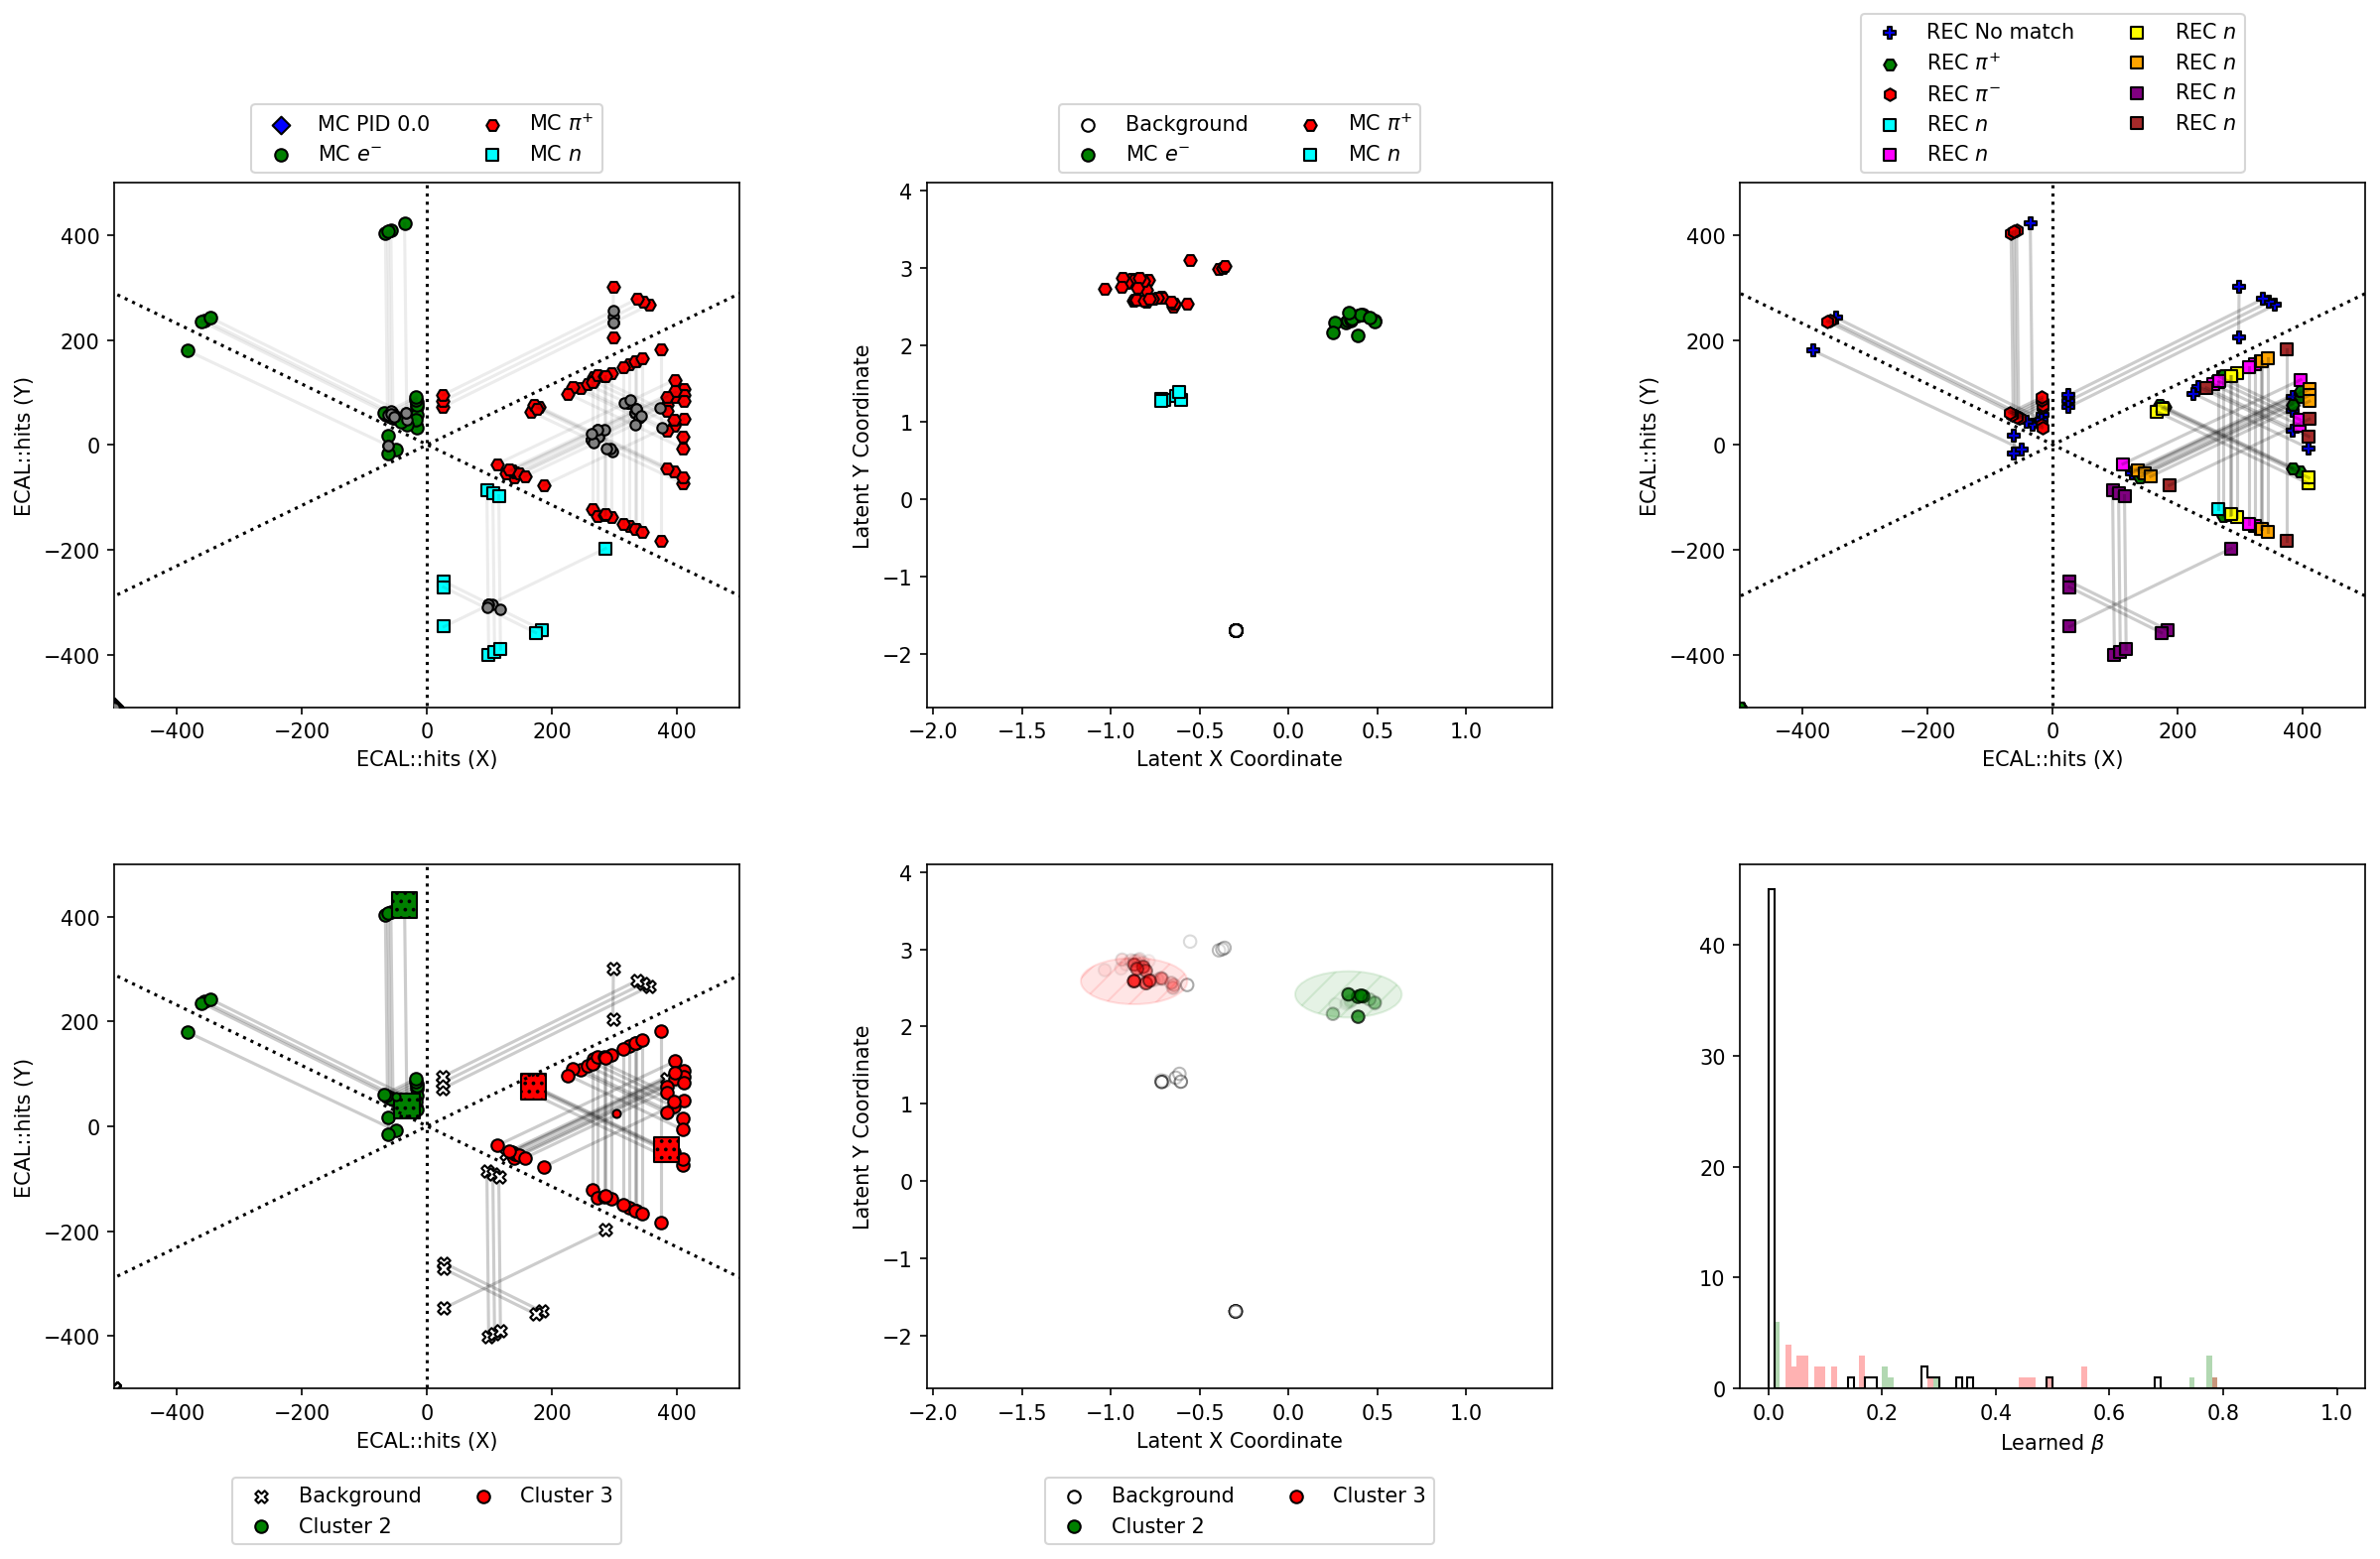

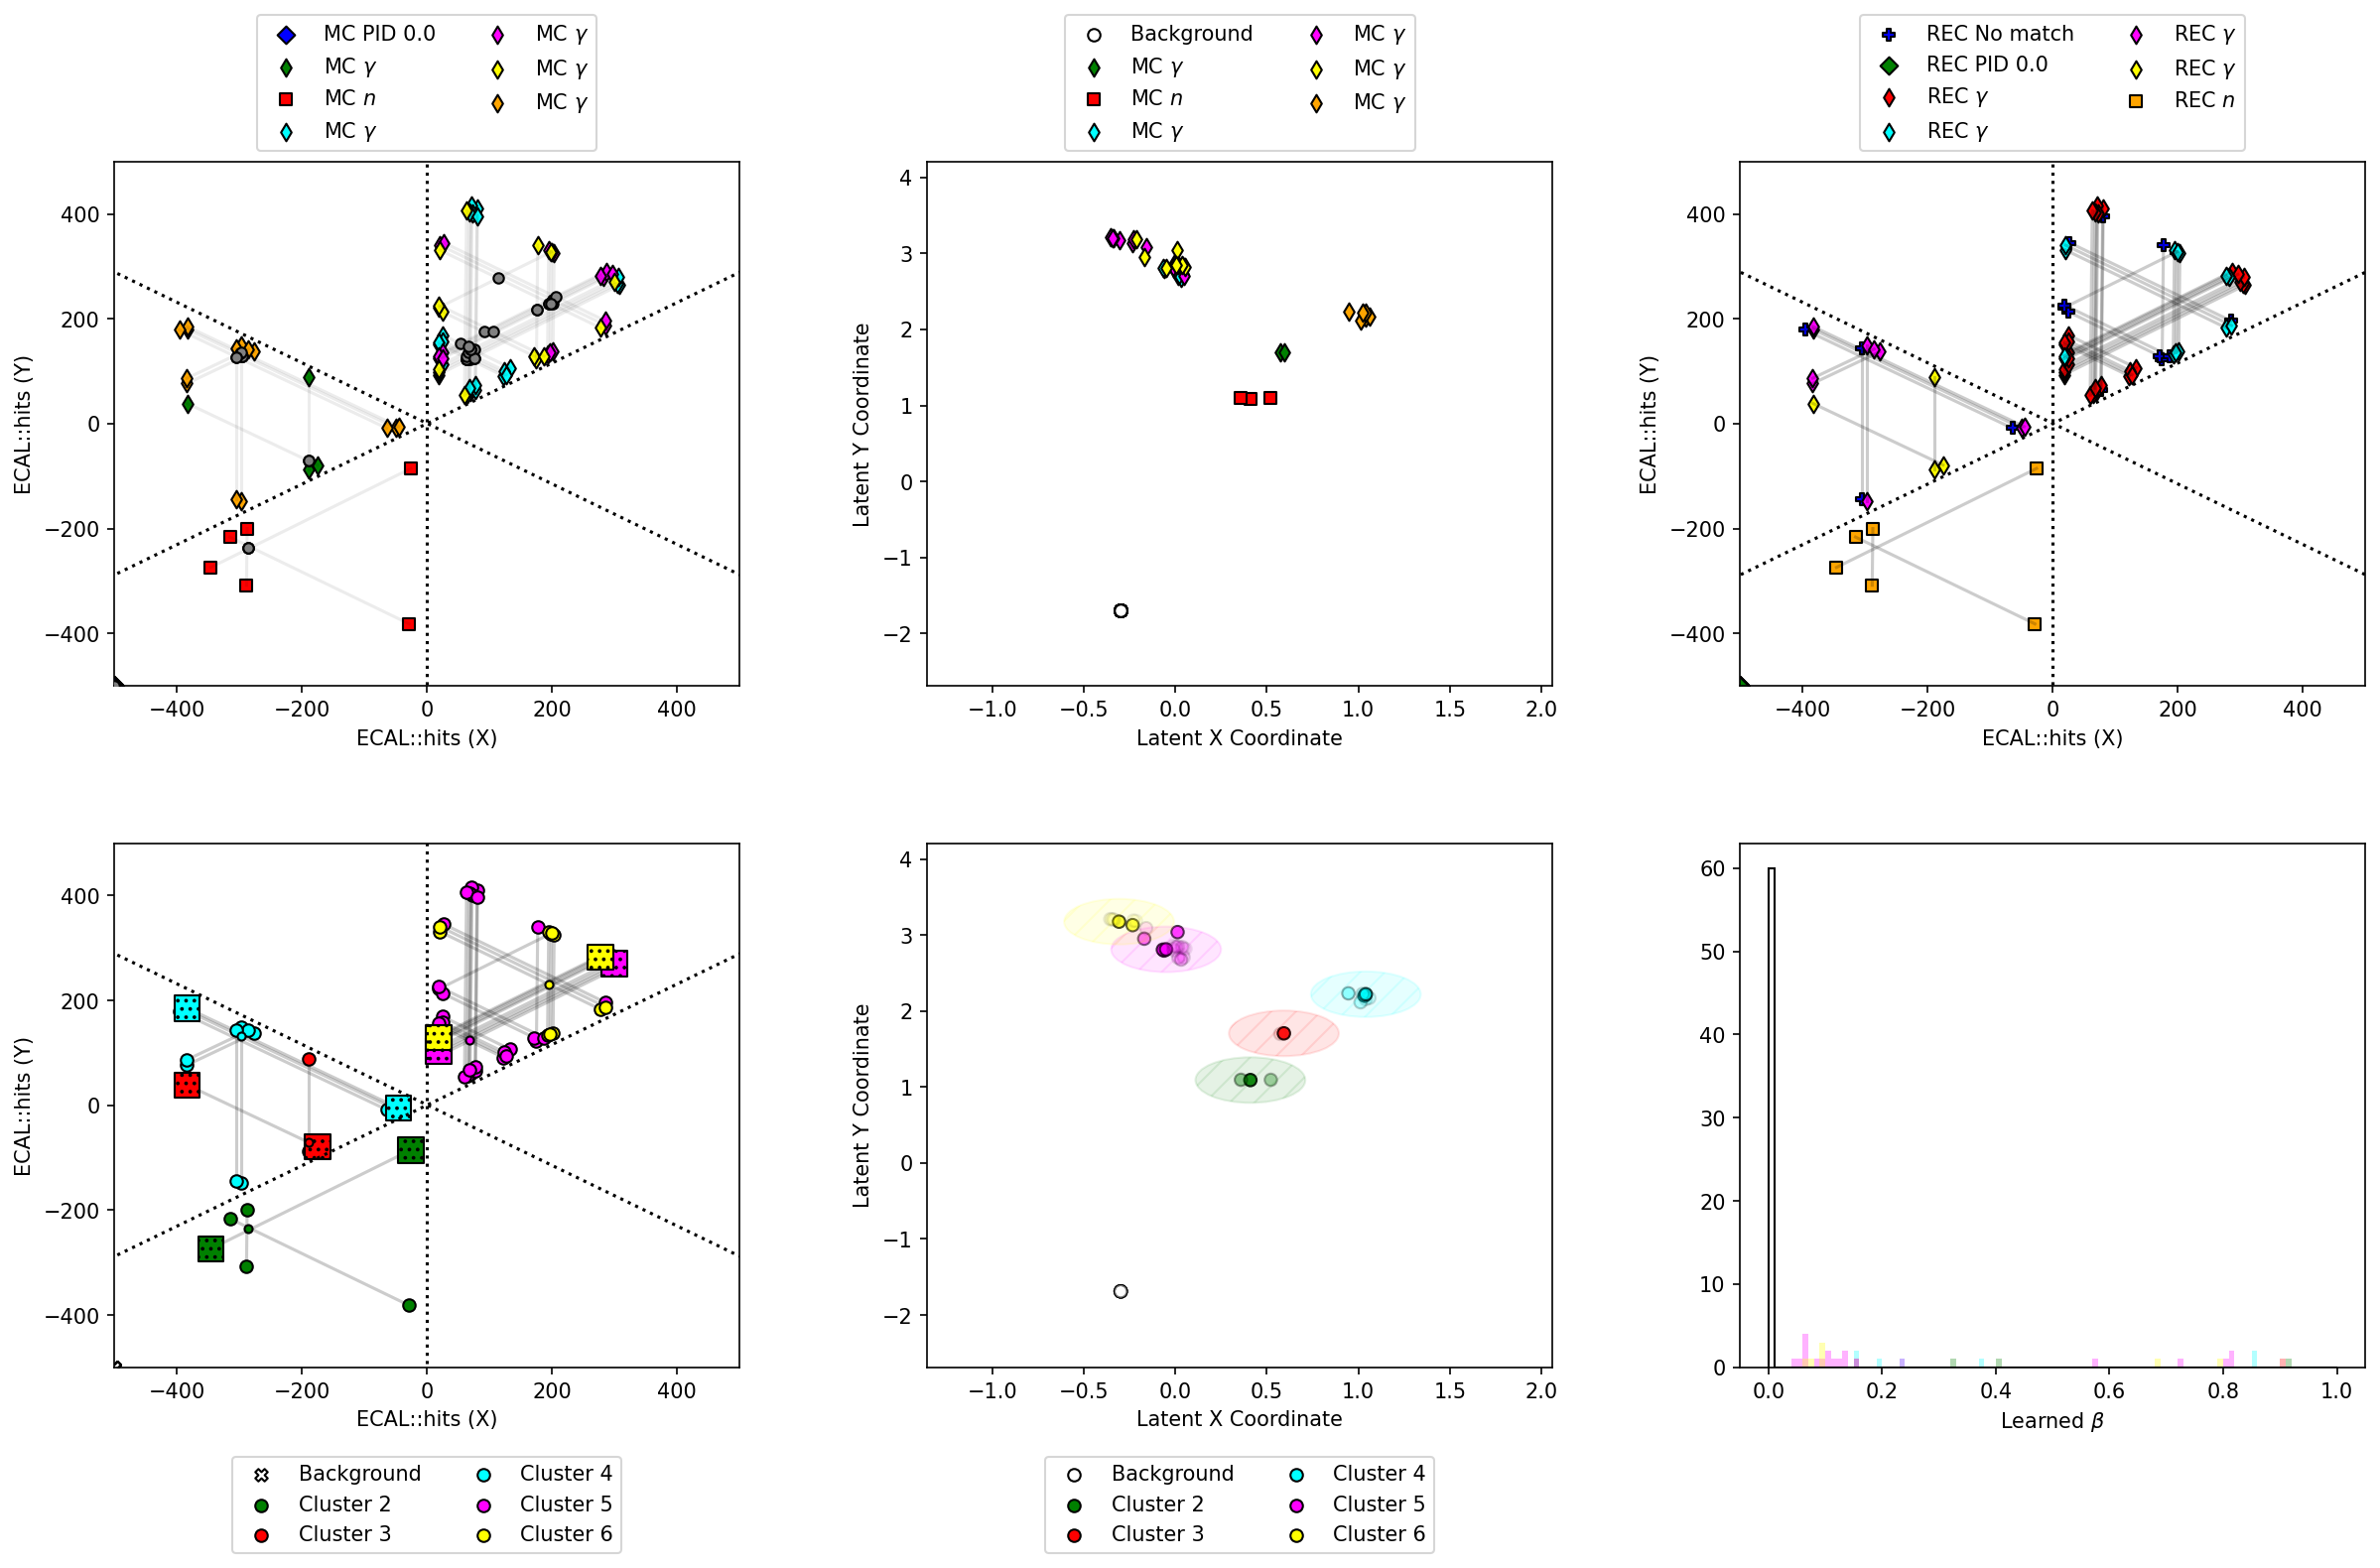

In [6]:
def plot(evaluator, ev):
    df = evaluator.get_event_dataframe(ev)
    #df = df[df.mc_pid==11]
    plotter = ModelEcalPlotter(df,use_clas_calo_scale=True)
    plotter.plot_all(tD=evaluator.tD)


print("Working Loss Dictionary\n", "*" * 100)
working_loss_df = working_eval.get_loss_df()
display(working_loss_df.mean(), working_loss_df)
plot(working_eval, 0)

print("Failing Loss Dictionary\n", "*" * 100)
failing_loss_df = failing_eval.get_loss_df()
display(failing_loss_df.mean(), failing_loss_df)
plot(failing_eval, 1)


In [7]:
df = working_eval.dataframe
Nev = 16
df = df[df.event<Nev]

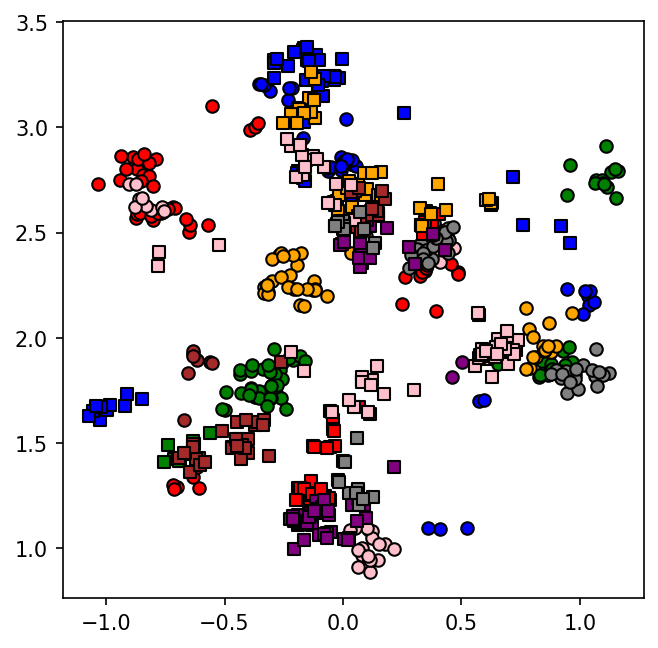

In [8]:
import matplotlib.pyplot as plt
# Define 8 marker colors and 8 marker styles
marker_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
marker_styles = ['o', 's', 'D', 'v', '^', '<', '>', 'p']

# Create the figure and axis
fig, axs = plt.subplots(1, 1, dpi=150, figsize=(5, 5))

# Loop through events
for i in range(Nev):
    subdf = df[df.event == i]
    subdf = subdf[subdf.unique_otid != -1]
    
    # Select color and marker style based on the event index
    color = marker_colors[i % len(marker_colors)]
    marker = marker_styles[i // len(marker_styles)]
    
    # Scatter plot with unique marker style and color
    axs.scatter(subdf.xc, subdf.yc, ec="k", color=color, marker=marker)

# Show the plot
plt.show()

# Below we analyze already predicted data ideally so ignore this if you are performing Jupyter model fitting











In [17]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf

# Append source directory to path
sys.path.append("../../src/")
pd.set_option('display.max_columns', 500)
# Import custom modules
from ECALDataAnalyzer import ECALDataAnalyzer
from TrainData import load_zip_train_test_data, load_unzip_data
from model_functions import make_gravnet_model
from loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
from callbacks import PlotCallback, CyclicalLearningRate, LossPlotCallback
from helper_functions import create_output_directory, create_gif_from_pngs
from global_params import *
import pandas as pd
df = pd.read_csv("../../projects/lerisque.09.19.2024.12.26/predict/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0000.h5")
df = df[(df.event==11)]

array([<Axes: xlabel='ECAL::hits (X)', ylabel='ECAL::hits (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='ECAL::hits (X)', ylabel='ECAL::hits (Y)'>,
       <Axes: xlabel='ECAL::hits (X)', ylabel='ECAL::hits (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='Learned $\\beta$'>], dtype=object)

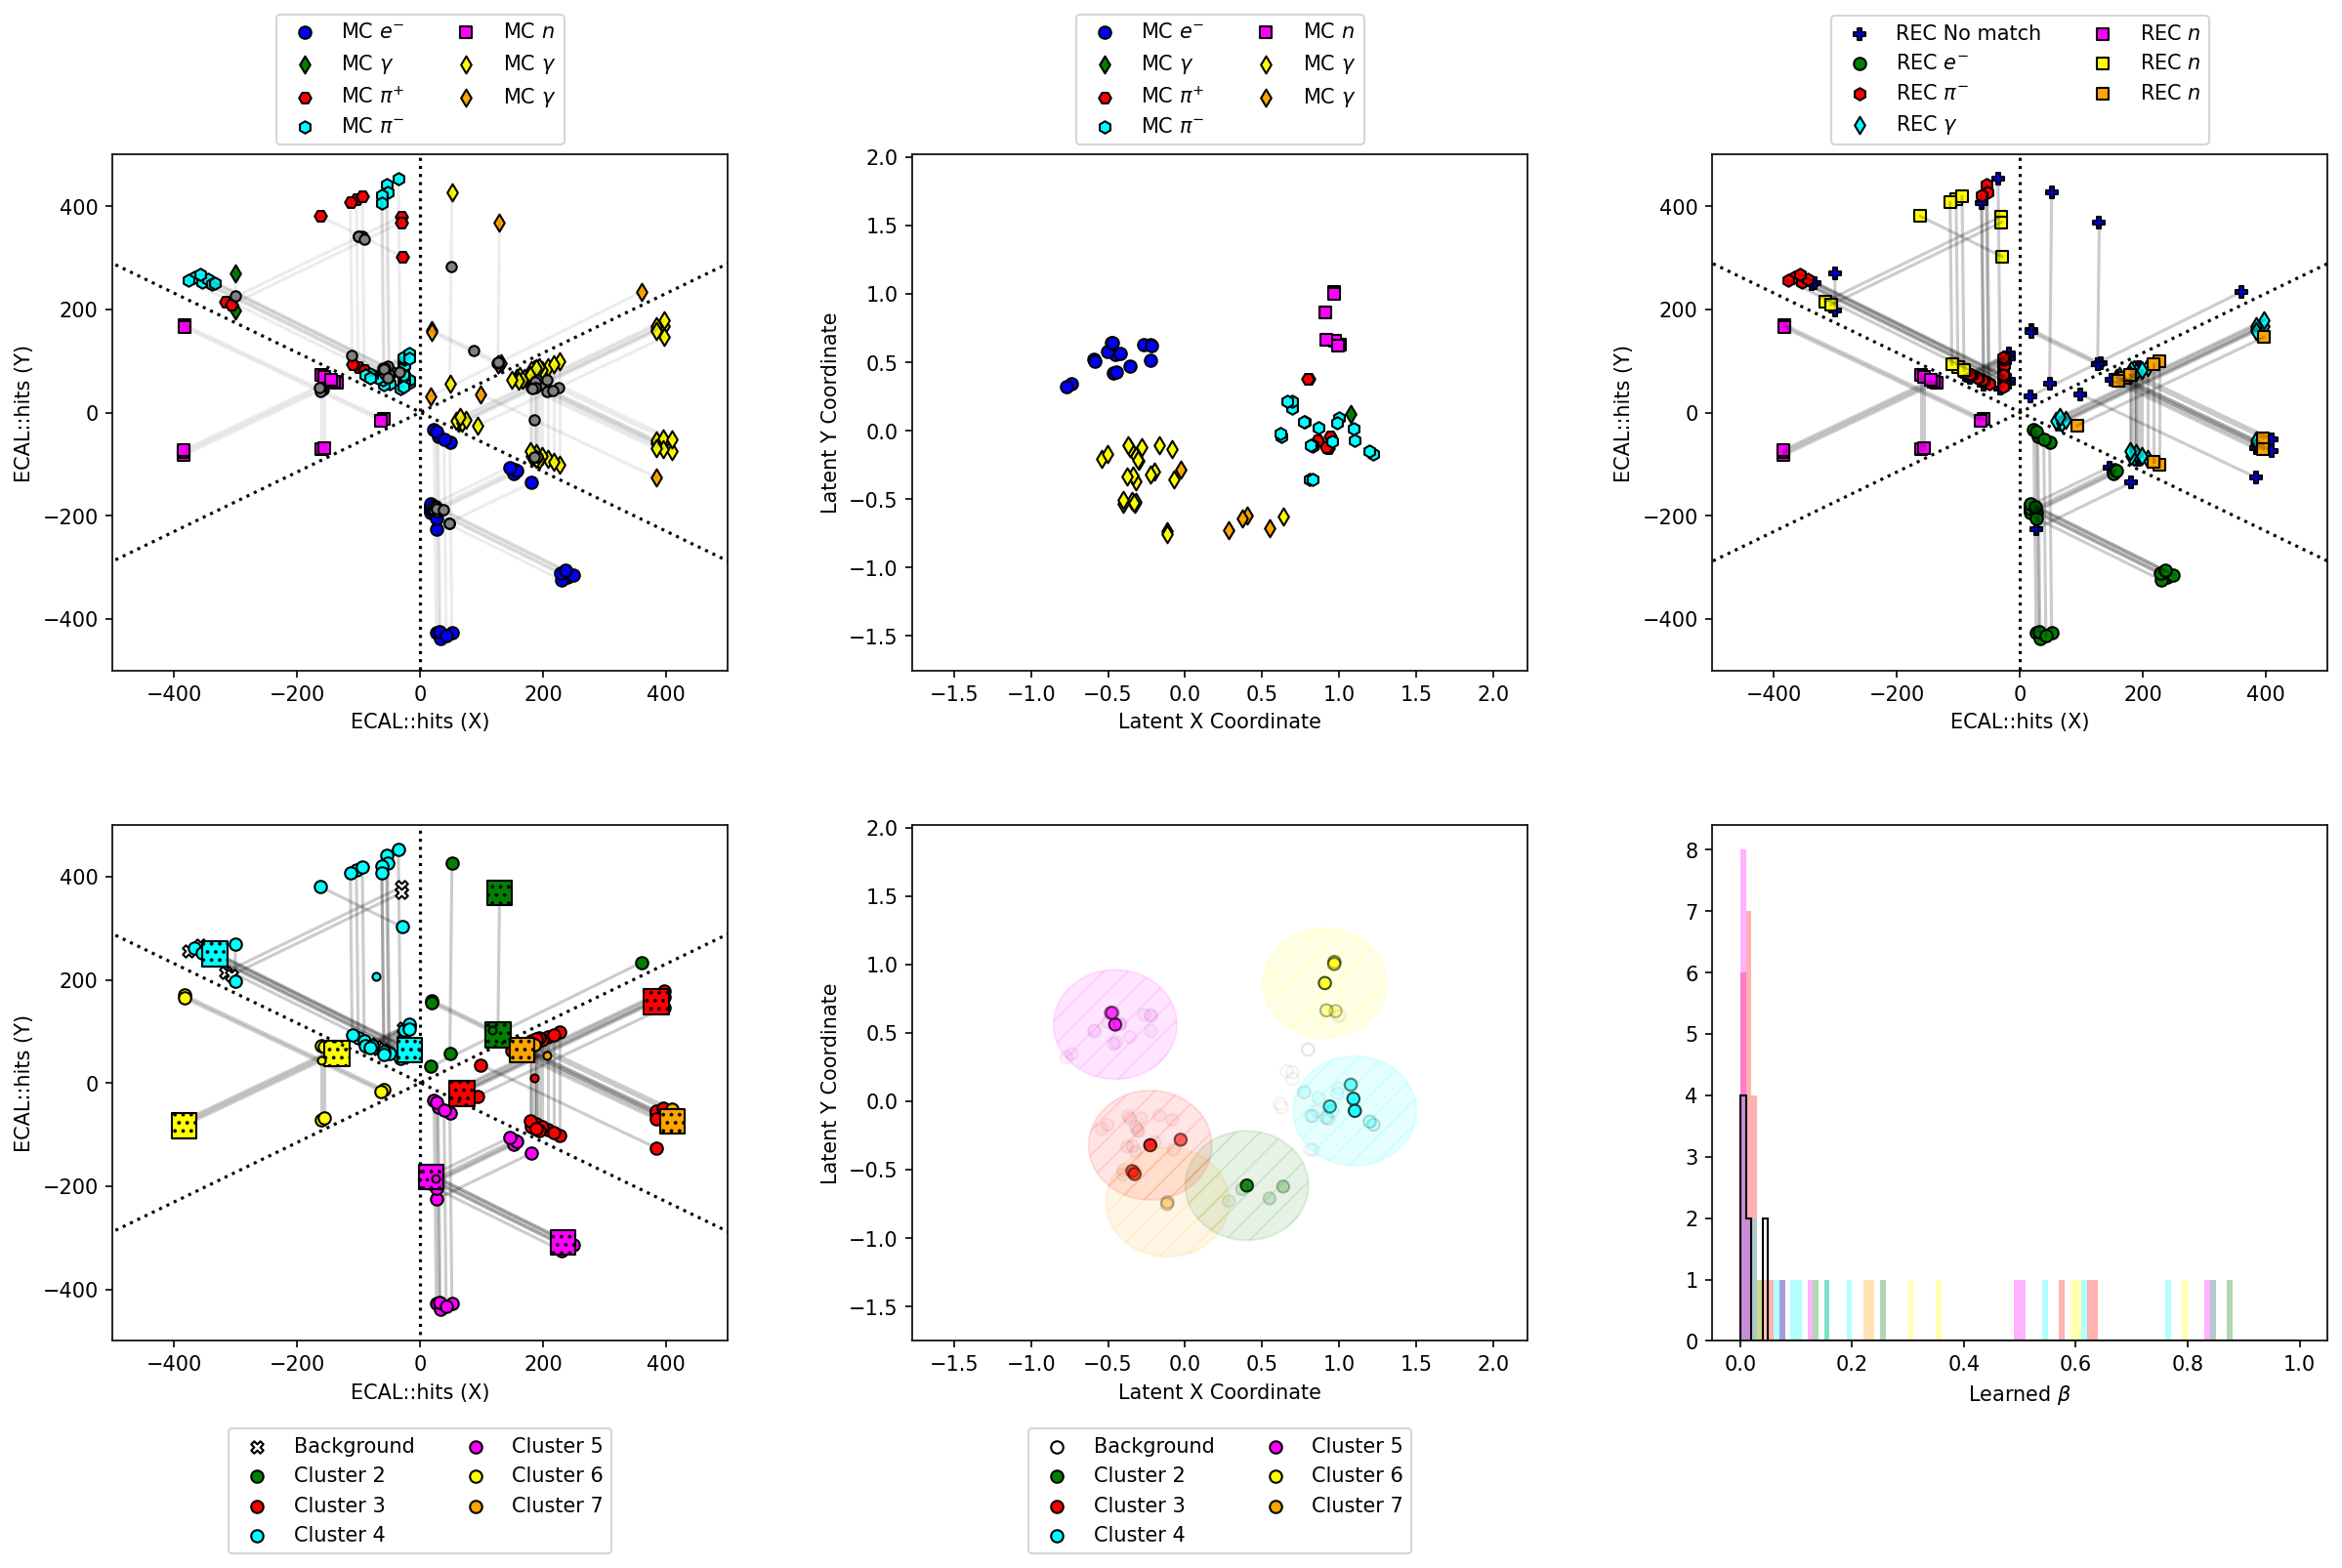

In [18]:
plotter = ModelEcalPlotter(df, use_clas_calo_scale=True)
plotter.plot_all(0.4)

In [9]:
df[(df.sector==6)&(df.layer<4)]

,Unnamed: 0,event,energy,time,xo,yo,zo,xe,ye,ze,sector,layer,centroid_x,centroid_y,centroid_z,is_3way_same_group,is_2way_same_group,is_3way_cross_group,is_2way_cross_group,rec_pid,pindex,mc_pid,unique_otid,beta,xc,yc,cluster_id,is_cluster_leader,id,cluster_x,cluster_y,cluster_z
152,158,1,0.003107,190.6979,18.811157,-350.85986,641.9960,292.39374,-192.90692,641.9960,6,1,230.71436,-227.23462,641.9960,0.0,0.0,1.0,0.0,-1.0,-1.0,2112.0,427.0,0.159215,0.297208,-0.088043,2,0,0,205.502899,-210.388031,655.341187
160,166,1,0.002573,175.8791,181.973200,-128.00587,695.2908,183.98938,-336.13000,610.7731,6,2,180.29144,-193.54144,668.6864,0.0,0.0,1.0,0.0,-1.0,-1.0,2112.0,427.0,0.786940,0.255329,-0.078147,2,1,0,205.502899,-210.388031,655.341187


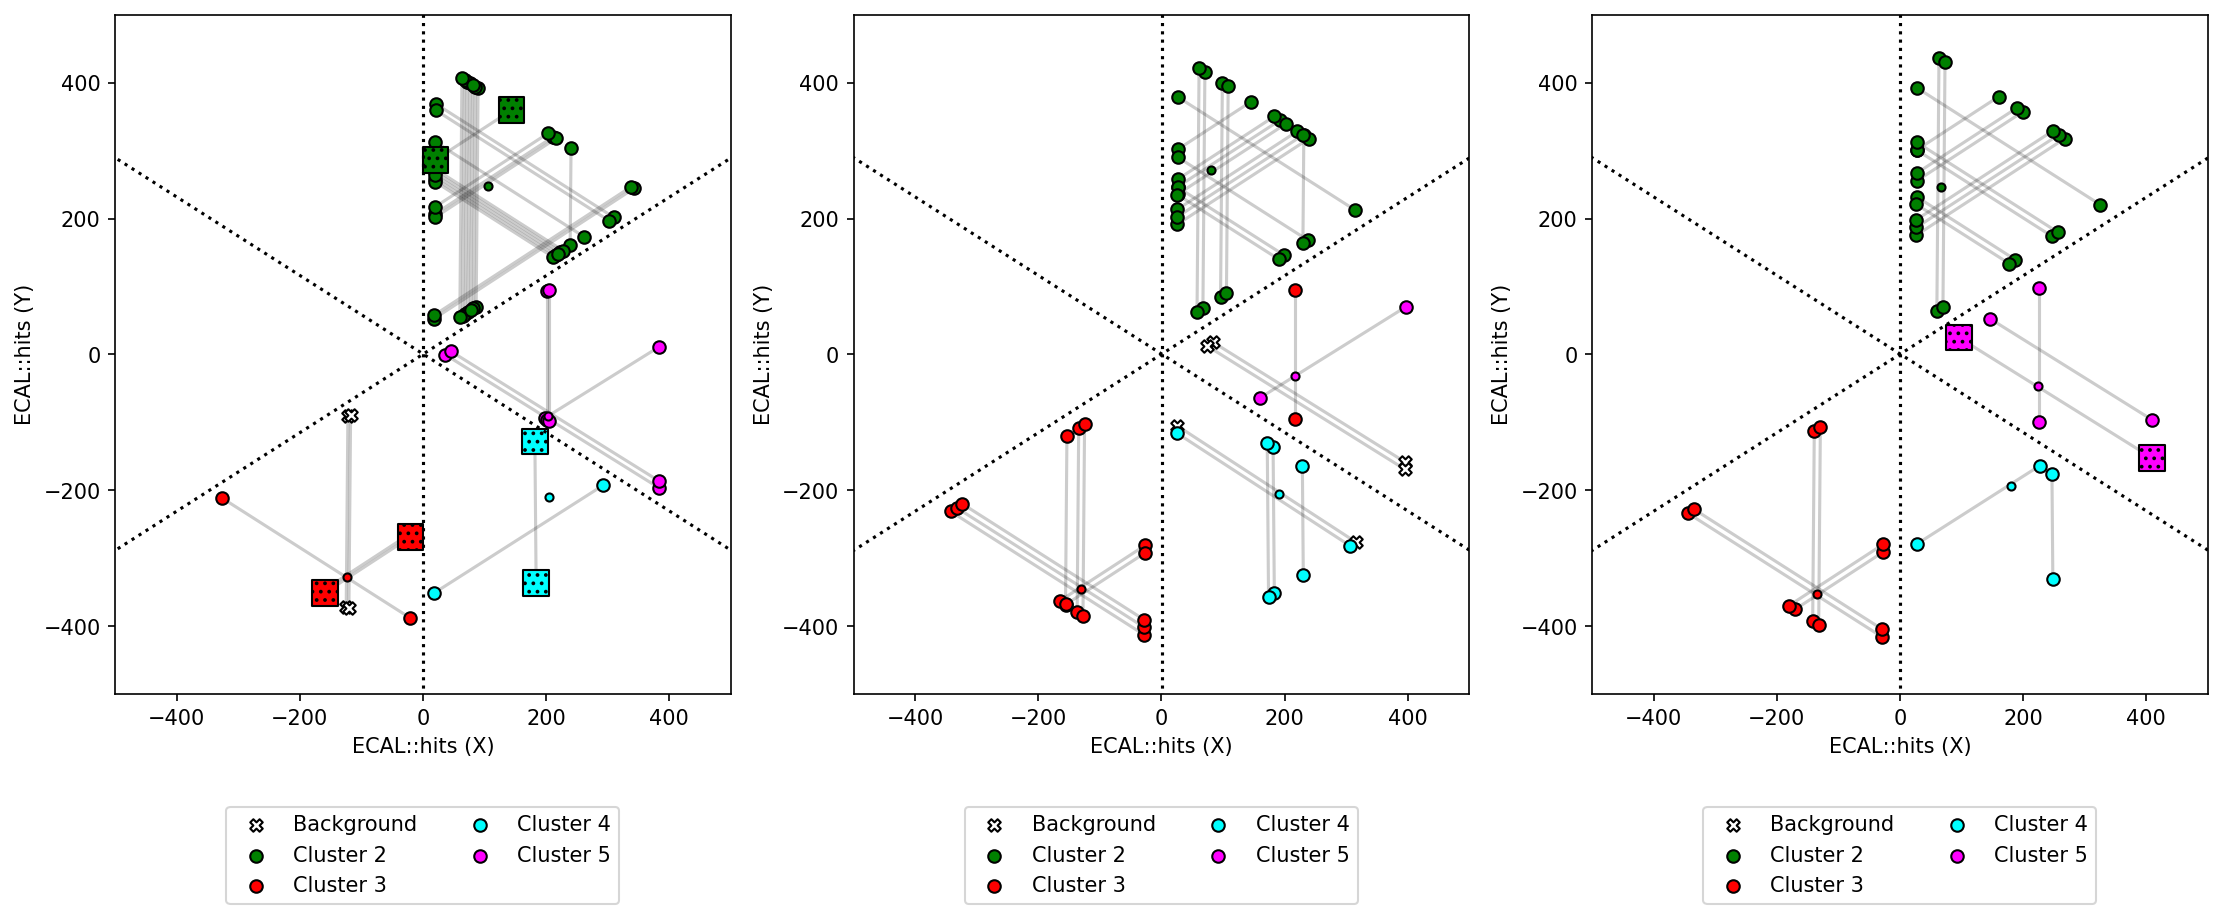

In [7]:
import matplotlib.pyplot as plt
plotter = ModelEcalPlotter(df, use_clas_calo_scale=True)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=150, facecolor='white')
axs = axs.flatten()
plotter.plot_clustered_ecal_peaks_v2(ax=axs[0],layergroup=[1,2,3])
plotter.plot_clustered_ecal_peaks_v2(ax=axs[1],layergroup=[4,5,6])
plotter.plot_clustered_ecal_peaks_v2(ax=axs[2],layergroup=[7,8,9])
plt.show()

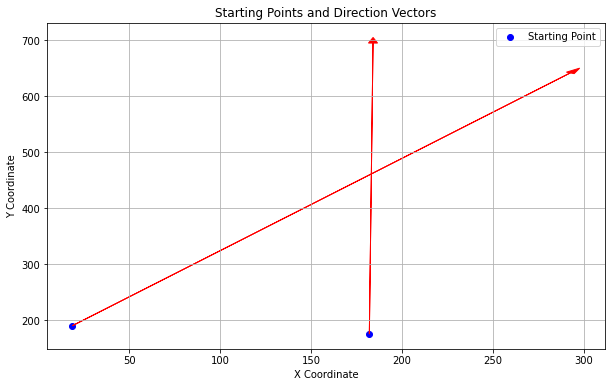

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame creation (you can replace this with your actual DataFrame)
data = {
    'Unnamed: 0': [152, 160],
    'event': [158, 166],
    'energy': [1, 1],
    'time': [0.003107, 0.002573],
    'yo': [190.6979, 175.8791],
    'xo': [18.811157, 181.973200],
    'ye': [641.9960, 695.2908],
    'xe': [292.39374, 183.98938],
    'sector': [6, 6],
    'layer': [1, 2],
    # Include other columns as necessary...
}

df = pd.DataFrame(data)

# Filter the DataFrame
filtered_df = df[(df.sector == 6) & (df.layer < 4)]

# Initialize lists for starting points and direction vectors
start_points = []
direction_vectors = []

# Loop through the filtered DataFrame
for index, row in filtered_df.iterrows():
    # Starting point (xo, yo)
    start_point = (row['xo'], row['yo'])
    start_points.append(start_point)
    
    # Endpoint (xe, ye)
    end_point = (row['xe'], row['ye'])
    
    # Direction vector (xe - xo, ye - yo)
    direction_vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])
    direction_vectors.append(direction_vector)

start_points = np.array(start_points)
direction_vectors = np.array(direction_vectors)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each starting point and draw the direction vector
for start, direction in zip(start_points, direction_vectors):
    plt.scatter(*start, color='blue', label='Starting Point' if 'Starting Point' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.arrow(start[0], start[1], direction[0], direction[1], 
              head_width=5, head_length=10, fc='red', ec='red')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Starting Points and Direction Vectors')
plt.grid()
plt.legend()
plt.show()

In [30]:
line_intersection_(start_points[0],direction_vectors[0],start_points[1],direction_vectors[1])

[183.08257355 461.67778973]
18.811157
181.97708163148997


array([183.08257355, 461.67778973])

In [43]:
# For train_X
all_train_reshaped_tensors = []

# Iterate through the train_X dataset and reshape each batch
for x in train_X.take(400):
    x_reshape = tf.reshape(x, [-1, 30])  # Reshape to (1600, 30)
    all_train_reshaped_tensors.append(x_reshape)  # Append reshaped tensor to the list

# Concatenate all tensors into one big tensor for train_X
train_big_tensor = tf.concat(all_train_reshaped_tensors, axis=0)

# For test_X
all_test_reshaped_tensors = []

# Iterate through the test_X dataset and reshape each batch
for x in test_X.take(400):
    x_reshape = tf.reshape(x, [-1, 30])  # Reshape to (1600, 30)
    all_test_reshaped_tensors.append(x_reshape)  # Append reshaped tensor to the list

# Concatenate all tensors into one big tensor for test_X
test_big_tensor = tf.concat(all_test_reshaped_tensors, axis=0)

# Now you have two large tensors:
# - train_big_tensor: shape (N_train, 30)
# - test_big_tensor: shape (N_test, 30)

print("Train tensor shape:", train_big_tensor.shape)
print("Test tensor shape:", test_big_tensor.shape)


Train tensor shape: (40000, 30)
Test tensor shape: (9900, 30)


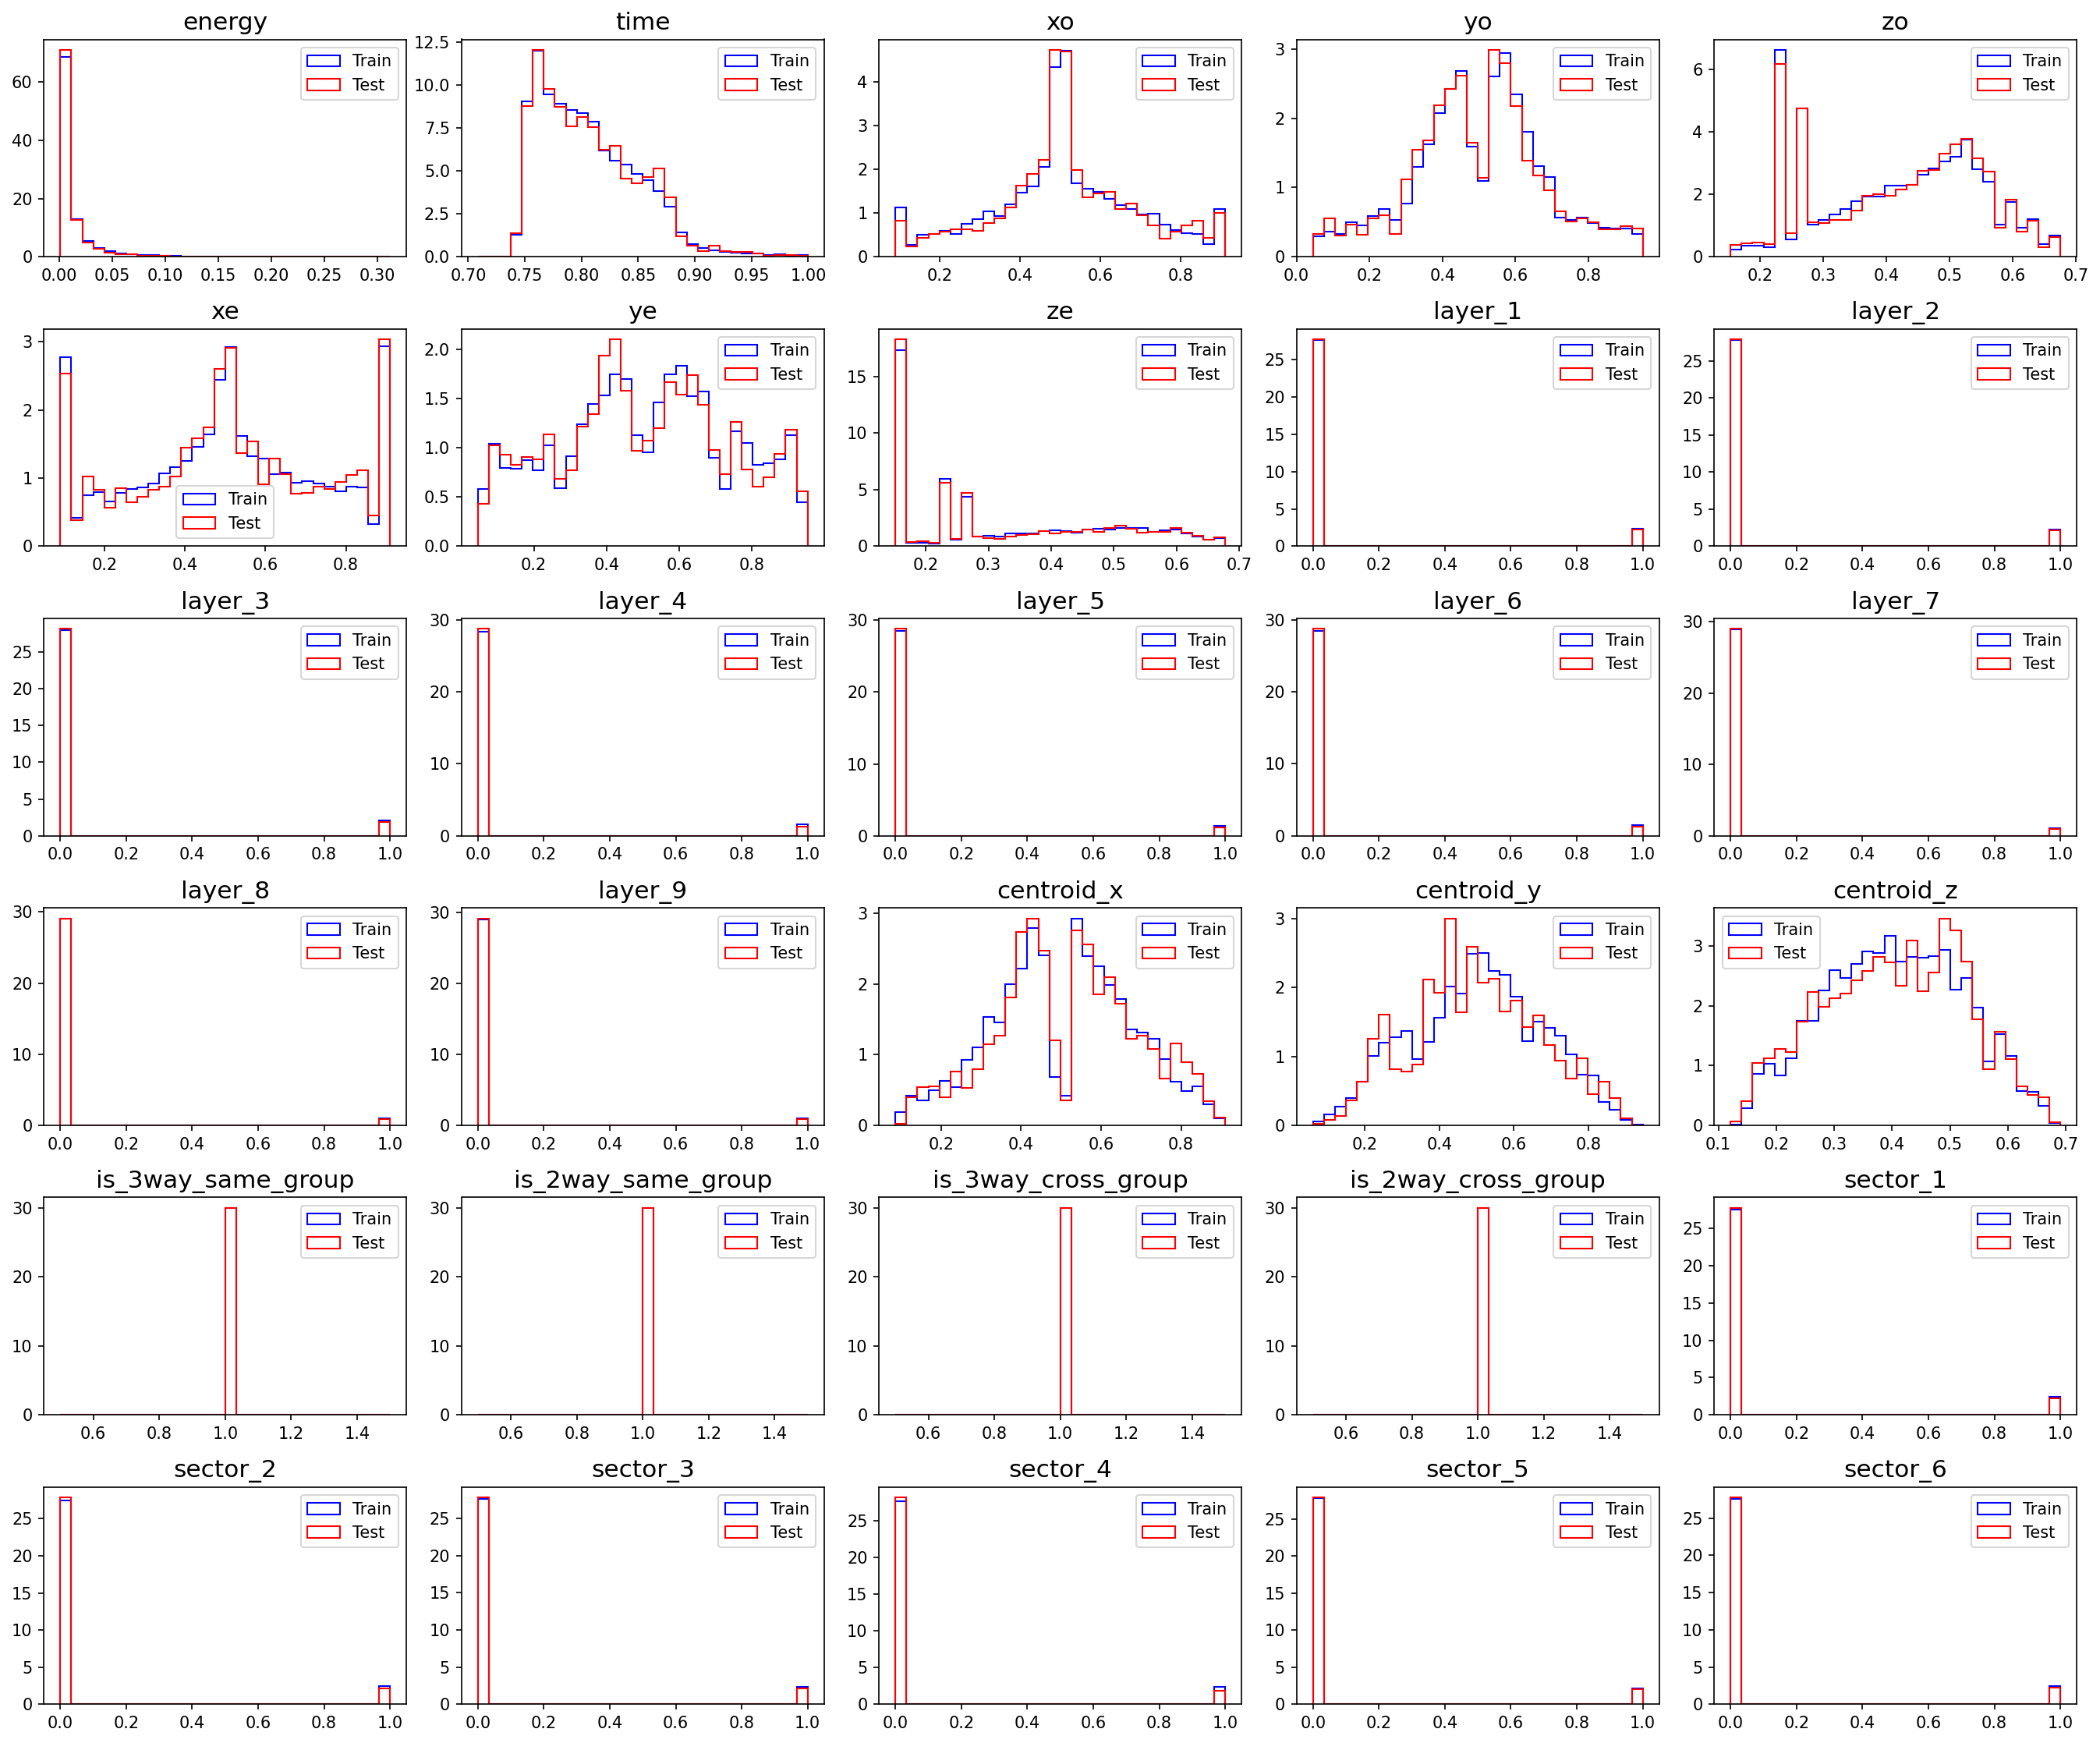

In [55]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Create a 6x5 grid of subplots
fig, axes = plt.subplots(6, 5, figsize=(6*3, 5*3), dpi=150)  # 6 rows, 5 columns of subplots
axes = axes.flatten()  # Flatten axes array for easier iteration

# Iterate through the 30 parameters (columns of tensors)
for i in range(30):
    # Extract the i-th parameter from train and test tensors
    train_param = train_big_tensor[:, i].numpy()
    test_param = test_big_tensor[:, i].numpy()



    # Get parameter name from the global list
    param_name = model_x_names[i]
    
    # For non-one-hot encoded parameters ignore 0 for the min_value
    if 'layer' not in param_name and 'sector' not in param_name :
        # Compute the range for the histograms to ensure they share the same axis limits
        min_value = min(train_param[train_param!=0].min(), test_param[test_param!=0].min())
        max_value = max(train_param.max(), test_param.max())
    else:
        # Compute the range for the histograms to ensure they share the same axis limits
        min_value = min(train_param.min(), test_param.min())
        max_value = max(train_param.max(), test_param.max())
    
    # Perform KS test to compare the two distributions
    ks_stat, p_value = ks_2samp(train_param, test_param)

    # Plot the histograms for train and test on the same subplot
    axes[i].hist(train_param, bins=30, range=(min_value, max_value), histtype="step", label='Train', color='blue', density=True)
    axes[i].hist(test_param, bins=30, range=(min_value, max_value), histtype="step", label='Test', color='red', density=True)

    # Set title and labels
    axes[i].set_title(f'{model_x_names[i]}', fontsize=15)

    # Add a legend with KS test result
    axes[i].legend([f'Train', f'Test', f'KS p-value: {p_value:.3f}'], fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [1]:
from Evaluator import Evaluator

ModuleNotFoundError: No module named 'Evaluator'

In [2]:
from ECALDataReader import ECALDataReader
reader = ECALDataReader("../../projects/lerisque.09.19.2024.12.26/predict/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0000_OC1.hipo")
x,y = [],[]
s=7
for event in reader.file:
    clusters_OC = reader.get_dict("ECAL::clusters_OC")
    x+=list(clusters_OC[clusters_OC.sector==s].x.values)
    y+=list(clusters_OC[clusters_OC.sector==s].y.values)

ModuleNotFoundError: No module named 'ECALDataReader'

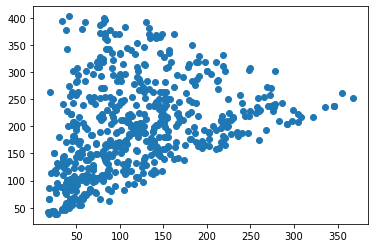

In [53]:
import matplotlib.pyplot as plt
plt.scatter(x,y)

In [57]:
arr = list(range(30))

In [59]:
np.argmax(arr[23:29])

5

In [60]:
df = pd.read_csv('../../projects/lerisque.09.19.2024.12.26/training/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0000.csv')
df = df[df.event==0]

In [61]:
df

,event,id,mc_pid,otid,sector,layer,energy,time,xo,yo,zo,xe,ye,ze,rec_pid,pindex,centroid_x,centroid_y,centroid_z,is_3way_same_group,is_2way_same_group,is_3way_cross_group,is_2way_cross_group
0,0,164.0,11.0,1.0,2.0,1.0,0.007013,162.385483,237.675323,158.861252,668.502625,19.931870,284.575500,668.502625,11.0,0.0,216.050718,170.355148,668.502625,1,0,0,0
1,0,135.0,11.0,1.0,2.0,1.0,0.059727,162.330673,245.742218,163.622452,664.699036,20.021746,293.942230,664.699036,11.0,0.0,215.884489,180.176704,664.699036,1,0,0,0
2,0,22.0,211.0,4.0,2.0,1.0,0.007767,163.345474,278.009796,182.667267,649.484802,20.381252,331.409180,649.484802,-1.0,-1.0,242.047794,200.755338,649.484802,0,0,1,0
3,0,23.0,211.0,4.0,2.0,2.0,0.015680,165.949173,20.013588,268.334198,676.382935,159.405167,350.622559,610.652405,-1.0,-1.0,0.000000,0.000000,0.000000,0,0,0,0
4,0,136.0,11.0,1.0,2.0,2.0,0.059500,157.337997,18.021458,62.693928,759.892029,334.484406,249.514496,610.662903,11.0,0.0,241.851338,197.285898,653.837249,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,114.0,2112.0,2.0,5.0,9.0,0.001720,152.949997,-131.996429,-398.411377,655.771423,-129.304474,-106.655807,774.219910,22.0,3.0,-130.821779,-126.084383,766.327181,1,0,0,0
93,0,104.0,2112.0,2.0,5.0,9.0,0.011620,155.446045,-92.856010,-421.009125,655.771423,-89.740265,-83.324059,792.866638,2112.0,2.0,-88.527246,-154.264784,764.072733,1,0,0,0
94,0,106.0,2112.0,2.0,5.0,9.0,0.013200,156.576340,-83.070900,-426.658539,655.771423,-79.849213,-77.491119,797.528320,2112.0,2.0,-81.968525,-154.203616,766.378875,1,0,0,0
95,0,108.0,2112.0,2.0,5.0,9.0,0.008300,157.955368,-73.285797,-432.307983,655.771423,-69.958160,-71.658188,802.190002,2112.0,2.0,-72.197875,-159.827464,766.389215,1,0,0,0


In [4]:
import h5py

# File path
file_path = '../../projects/lerisque.09.19.2024.12.26/training/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0000.h5'

# Open the HDF5 file
with h5py.File(file_path, 'r') as h5_file:
    # Read the 'X' table
    X = h5_file['X'][:]


In [17]:
X[:,:,1].flatten()

array([0.7876814, 0.776907 , 0.8254482, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [20]:
X[0,10]

array([0.04293333, 0.82217455, 0.38698384, 0.4139073 , 0.44908753,
       0.3841709 , 0.12353747, 0.15429474, 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.38802084, 0.3679732 , 0.40246832,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ],
      dtype=float32)